
# Asteroid Hazard Classification (Btech Project Group 45)

### Dictionary (Columns)
- SPK-ID: Object primary SPK-ID.
- Object ID: Object internal database ID.
- Object fullname: Object full name/designation.
- pdes: Object primary designation.
- name: Object IAU name.
- class: Orbit Class.
- NEO: Near-Earth Object (NEO) flag.
- PHA: Potentially Hazardous Asteroid (PHA) flag. (Target)
- H: Absolute magnitude parameter.
- diameter: object diameter from equivalent sphere (km).
- Albedo: Geometric albedo.
- Diameter_sigma: 1-sigma uncertainty in object diameter (km).
- Orbit_id: Orbit solution ID.
- Epoch: Epoch of osculation in Julian day form (TDB).
- Epoch_mjd: Epoch of osculation in modified Julian day form (TDB).
- Epoch_cal: Epoch of osculation in calendar date/time form (TDB).
- Equinox: Equinox of reference frame.
- e: Eccentricity.
- a: Semi-major axis (au).
- q: perihelion distance (au).
- i: inclination; angle with respect to x-y ecliptic plane.
- om: Longitude of the ascending node (deg).
- w: Argument of perihelium (deg).
- ma: Mean Anomaly (deg).
- ad: Aphelion distance (au).
- n: Mean Motion (deg/au).
- tp: Time of perihelion passage (TDB).
- tp_cal: Time of perihelion passage (Apparently, calibrated) (TDB).
- per: Sideral Orbital Period (d).
- per_y: Sideral Orbital Period (years).
- moid: Earth Minimum Orbit Intersection Distance (au).
- moid_ld: Earth Minimum Orbit Intersection Distance (ld).
- sigma_e: Eccentricity (1 - sigma uncertainty).
- sigma_a: Semi-major axis (1 - sigma uncertainty) (au).
- sigma_q: Perihelion distance (1 - sigma uncertainty) (au).
- sigma_i: Inclination (1 - sigma uncertainty) (au).
- sigma_om: Long. of the asc. node (1 - sigma uncertainty) (deg).
- sigma_w: Argument of perihelion (1 - sigma uncertainty) (deg).
- sigma_ma: Mean anomaly (1 - sigma uncertainty) (deg).
- sigma_ad: Aphelion distance (1 - sigma uncertainty) (au).
- sigma_n: Mean motion (1 - sigma uncertainty) (deg/d).
- sigma_tp: Time of peri. passage (1 - sigma uncertainty) (au).
- sigma_per: Sideral orbital period (1 - sigma uncertainty) (d).

## 1) Importing Libraries and Loading the Dataset

In [1]:
# Importing Libraries:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew, mannwhitneyu, chi2_contingency

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, RFECV
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import make_pipeline
import missingno as ms

import joblib
import os

In [2]:
# Loading Data:
df_raw = pd.read_csv("dataset.csv", dtype={"pdes":"str",
                                           "name":"str",
                                           "prefix":"str"})

In [3]:
# Making a copy of the dataset:
df = df_raw.copy()

## 2) Data Cleaning

In [4]:
# Information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [5]:
# Deleting some useless columns:
df.drop(columns=["prefix", "name", "spkid", "orbit_id", 'pdes'], inplace=True)
print(f"Shape: {df.shape}")

Shape: (958524, 40)


 - RMS column

  After searching a lot about this columns, I could not find anthing about it, so as I am no keen on it, I will drop it as well.

In [6]:
# Deleting rms column:
df.drop(columns=['rms'], inplace=True)

Let's see the columns that I want to set as index.

In [7]:
# Unique values of the full_name column:
df['full_name'].unique()

array(['     1 Ceres', '     2 Pallas', '     3 Juno', ...,
       '       (6344 P-L)', '       (2060 T-2)', '       (2678 T-3)'],
      dtype=object)

As we can see that at the beginning of the names, there are some blank spaces, so we need to fix it before set them as index.

In [8]:
# Removing the blank space in front of the names:
df['full_name'] = df['full_name'].str.strip(" ")
df['full_name'].unique()

array(['1 Ceres', '2 Pallas', '3 Juno', ..., '(6344 P-L)', '(2060 T-2)',
       '(2678 T-3)'], dtype=object)

In [9]:
# Setting ID  and Full_name as a multindex:
df.set_index(["id", "full_name"], inplace=True)

- Moid and Moid_ld columns

Both of them measure distances, and the difference between them is that the first one measures distance in astronomical units, which means it measures distance based on the distance between the Earth and the Sun. On the other hand, the second attribute measures the distance using a unit called lunar distance, which has a very objective description and is easy to interpret.

In [10]:
# Correlation between moid and moid_ld
df[['moid', 'moid_ld']].corr()

,moid,moid_ld
moid,1.0,1.0
moid_ld,1.0,1.0


As we can expect, they are highly correlated, so we can choose one of them to represent the information about distance. With this in mind, we will drop the moid_ld column because its range is much larger than that of the moid column.

In [11]:
# Dropping the moid_ld column:
df.drop(columns=['moid_ld'], inplace=True)

 - tp and tp_cal columns

Accondingly to the  Nasa website https://ssd.jpl.nasa.gov/tools/sbdb_query.html#!#results, both of these columns have the same name "Time of the Perihelion Passage (TDB)". Furthermore, the first attribute represents the perihelion value itself and the second attribute can be a calibrated version of the tp variable. These attributes carry information about the time, which an asteroid, orbiting the Sun, is closest to it. These columns are presented in Unix Timestamp.

In [12]:
# Displaying the corelation of tp and tp_cal:
display(df[['tp', 'tp_cal']].corr())

,tp,tp_cal
tp,1.000000,0.998251
tp_cal,0.998251,1.000000


As we can see above, they are hightly correlated but I will not drop any of them for now, because I want to explore them more on the next topic of the project.

In [13]:
# Looking at the first five rows:
df.head()

,,neo,pha,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,equinox,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class
id,full_name,,,,,,,,,,,,,,,,,,,,,
a0000001,1 Ceres,N,N,3.40,939.400,0.0900,0.200,2458600.5,58600,20190427.0,J2000,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA
a0000002,2 Pallas,N,N,4.20,545.000,0.1010,18.000,2459000.5,59000,20200531.0,J2000,...,8.832200e-08,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA
a0000003,3 Juno,N,N,5.33,246.596,0.2140,10.594,2459000.5,59000,20200531.0,J2000,...,8.139200e-08,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA
a0000004,4 Vesta,N,N,3.00,525.400,0.4228,0.200,2458600.5,58600,20190427.0,J2000,...,1.928600e-09,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA
a0000005,5 Astraea,N,N,6.90,106.699,0.2740,3.140,2459000.5,59000,20200531.0,J2000,...,6.092400e-08,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA


Missing Data

In [14]:
# Looking for missing data:
df.isna().sum().sort_values(ascending=False).to_frame()

,0
albedo,823421
diameter_sigma,822443
diameter,822315
sigma_ad,19926
sigma_per,19926
sigma_e,19922
sigma_n,19922
sigma_a,19922
sigma_q,19922
sigma_tp,19922


In [15]:
# Deleting columns that hava more than 50% of missing data:
df.dropna(thresh=0.5*len(df), axis=1, inplace=True)
print(f"Shape: {df.shape}")

Shape: (958524, 33)


In [16]:
# Looking for missing data:
df.isna().sum().sort_values(ascending=False)

sigma_ad     19926
sigma_per    19926
sigma_n      19922
sigma_e      19922
sigma_a      19922
sigma_q      19922
sigma_tp     19922
sigma_w      19922
sigma_om     19922
sigma_ma     19922
sigma_i      19922
moid         19921
pha          19921
H             6263
neo              4
ad               4
per              4
ma               1
per_y            1
om               0
w                0
tp               0
n                0
e                0
a                0
epoch_mjd        0
epoch            0
equinox          0
epoch_cal        0
i                0
q                0
tp_cal           0
class            0
dtype: int64

In [17]:
# Description of the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 958524 entries, ('a0000001', '1 Ceres') to ('bT3S2678', '(2678 T-3)')
Data columns (total 33 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   neo        958520 non-null  object 
 1   pha        938603 non-null  object 
 2   H          952261 non-null  float64
 3   epoch      958524 non-null  float64
 4   epoch_mjd  958524 non-null  int64  
 5   epoch_cal  958524 non-null  float64
 6   equinox    958524 non-null  object 
 7   e          958524 non-null  float64
 8   a          958524 non-null  float64
 9   q          958524 non-null  float64
 10  i          958524 non-null  float64
 11  om         958524 non-null  float64
 12  w          958524 non-null  float64
 13  ma         958523 non-null  float64
 14  ad         958520 non-null  float64
 15  n          958524 non-null  float64
 16  tp         958524 non-null  float64
 17  tp_cal     958524 non-null  float64
 18  per        958520 non-

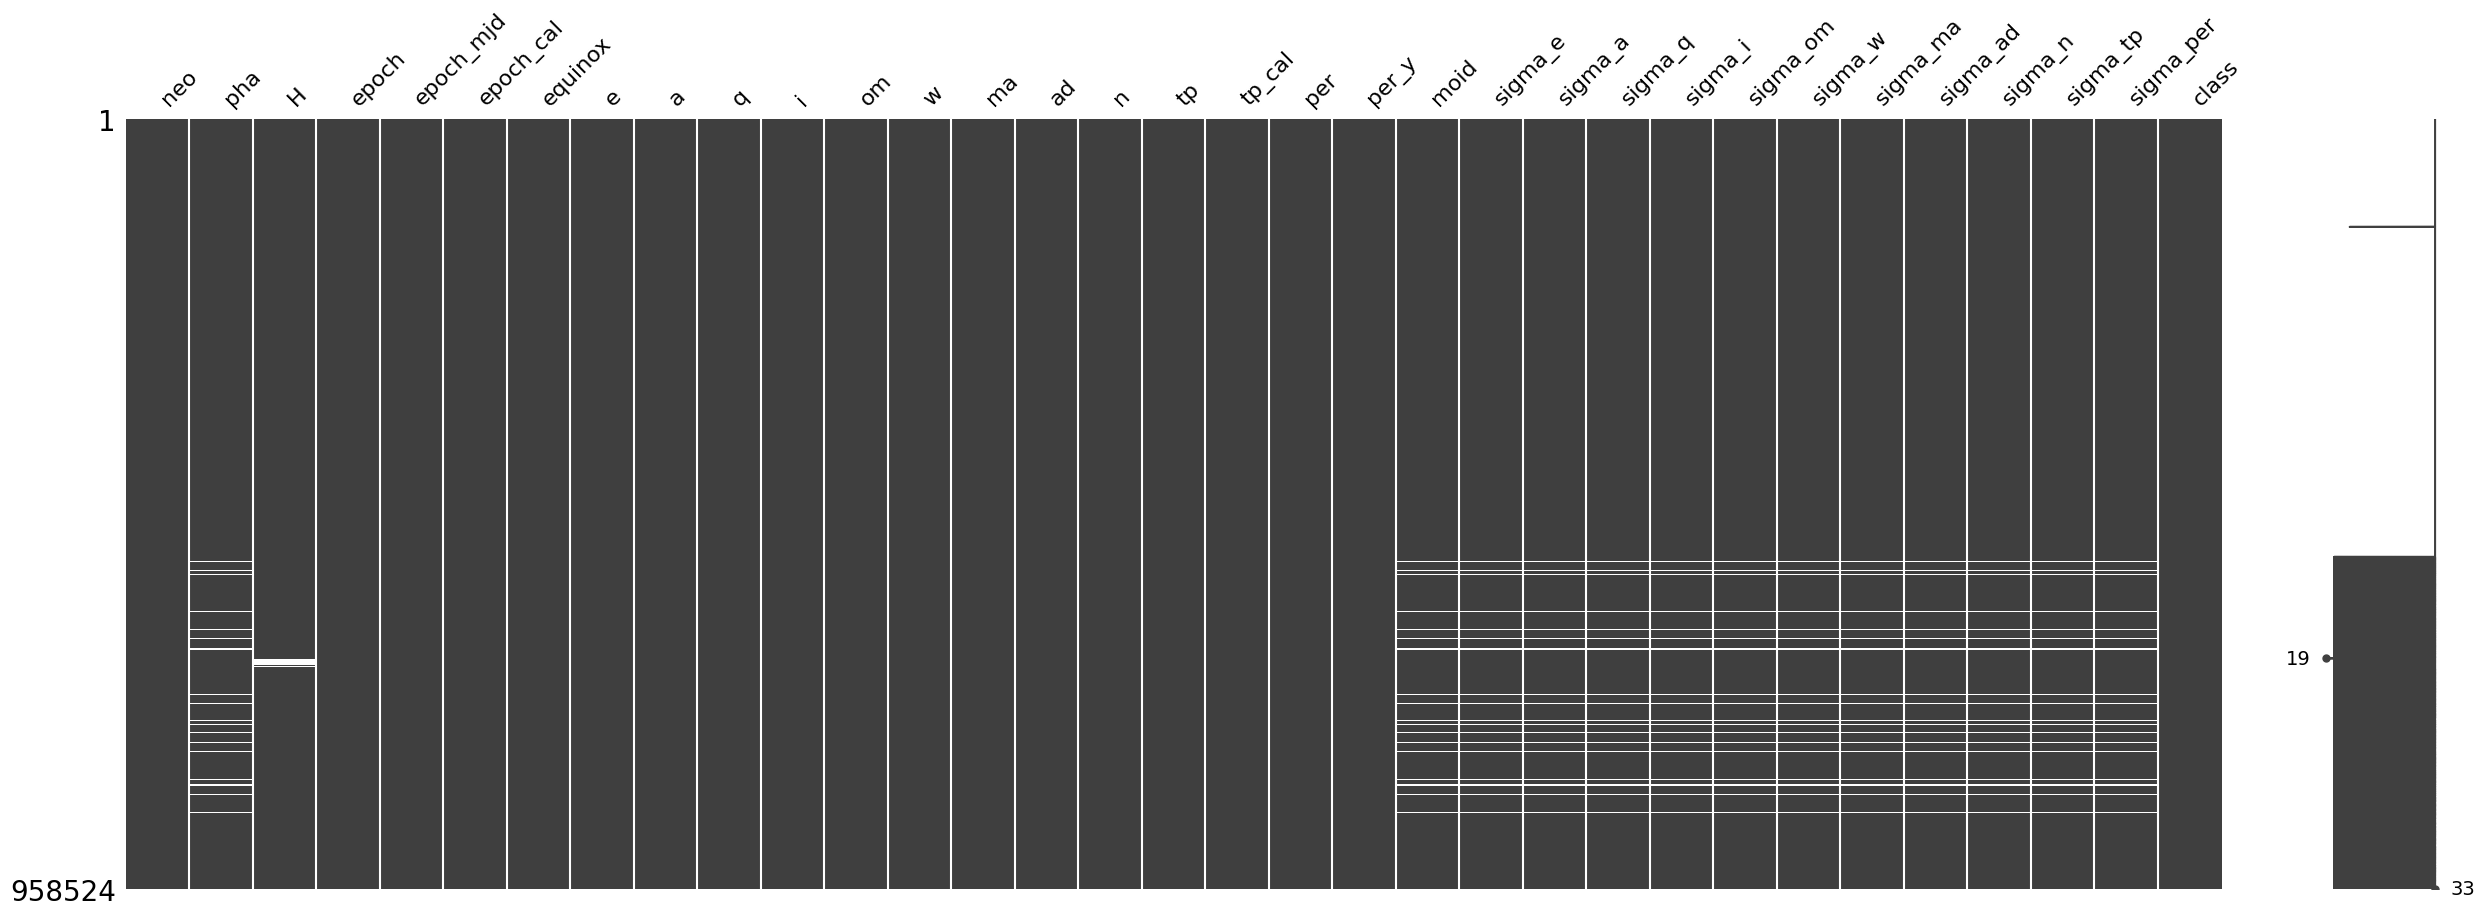

In [18]:
# Plottinhg the missing data matrix:
ms.matrix(df, figsize=(30, 10));

Apparently all the missing data in the *sigma* columns and in the *moid* column are related to the missing data contained in the Target column *pha*.

In [19]:
# Looking at the missing data of the sigma columns:
df_2 = df[["pha", "moid", "sigma_e", "sigma_a",
    "sigma_q", "sigma_i", "sigma_om",
    "sigma_w", "sigma_ma", "sigma_ad",
    "sigma_n", "sigma_tp", "sigma_per"]]

df_2[df["pha"].isnull()]

,,pha,moid,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per
id,full_name,,,,,,,,,,,,,
bJ39R00R,(1939 RR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bJ90O05K,(1990 OK5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bJ91R28N,(1991 RN28),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bJ93T11C,(1993 TC11),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bJ94A09F,(1994 AF9),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bK20K03Q,(2020 KQ3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bK20K03R,(2020 KR3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bK20K03V,(2020 KV3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see above, 19921 from 19922 forom the missing data is related to the target column. Since we do not have data of the dependent variable for those obsrvations, we can drop all of them basend on the target.

In [20]:
# Dropping observations with missing data in the dependent variable:
df.dropna(subset="pha", inplace=True)
df.isna().sum().sort_values(ascending=False).to_frame()

,0
H,6262
sigma_ad,5
sigma_per,5
neo,4
ad,4
per,4
sigma_om,1
ma,1
sigma_tp,1
sigma_e,1


Let's look at the missing data of the Absolute magnitude parameter.

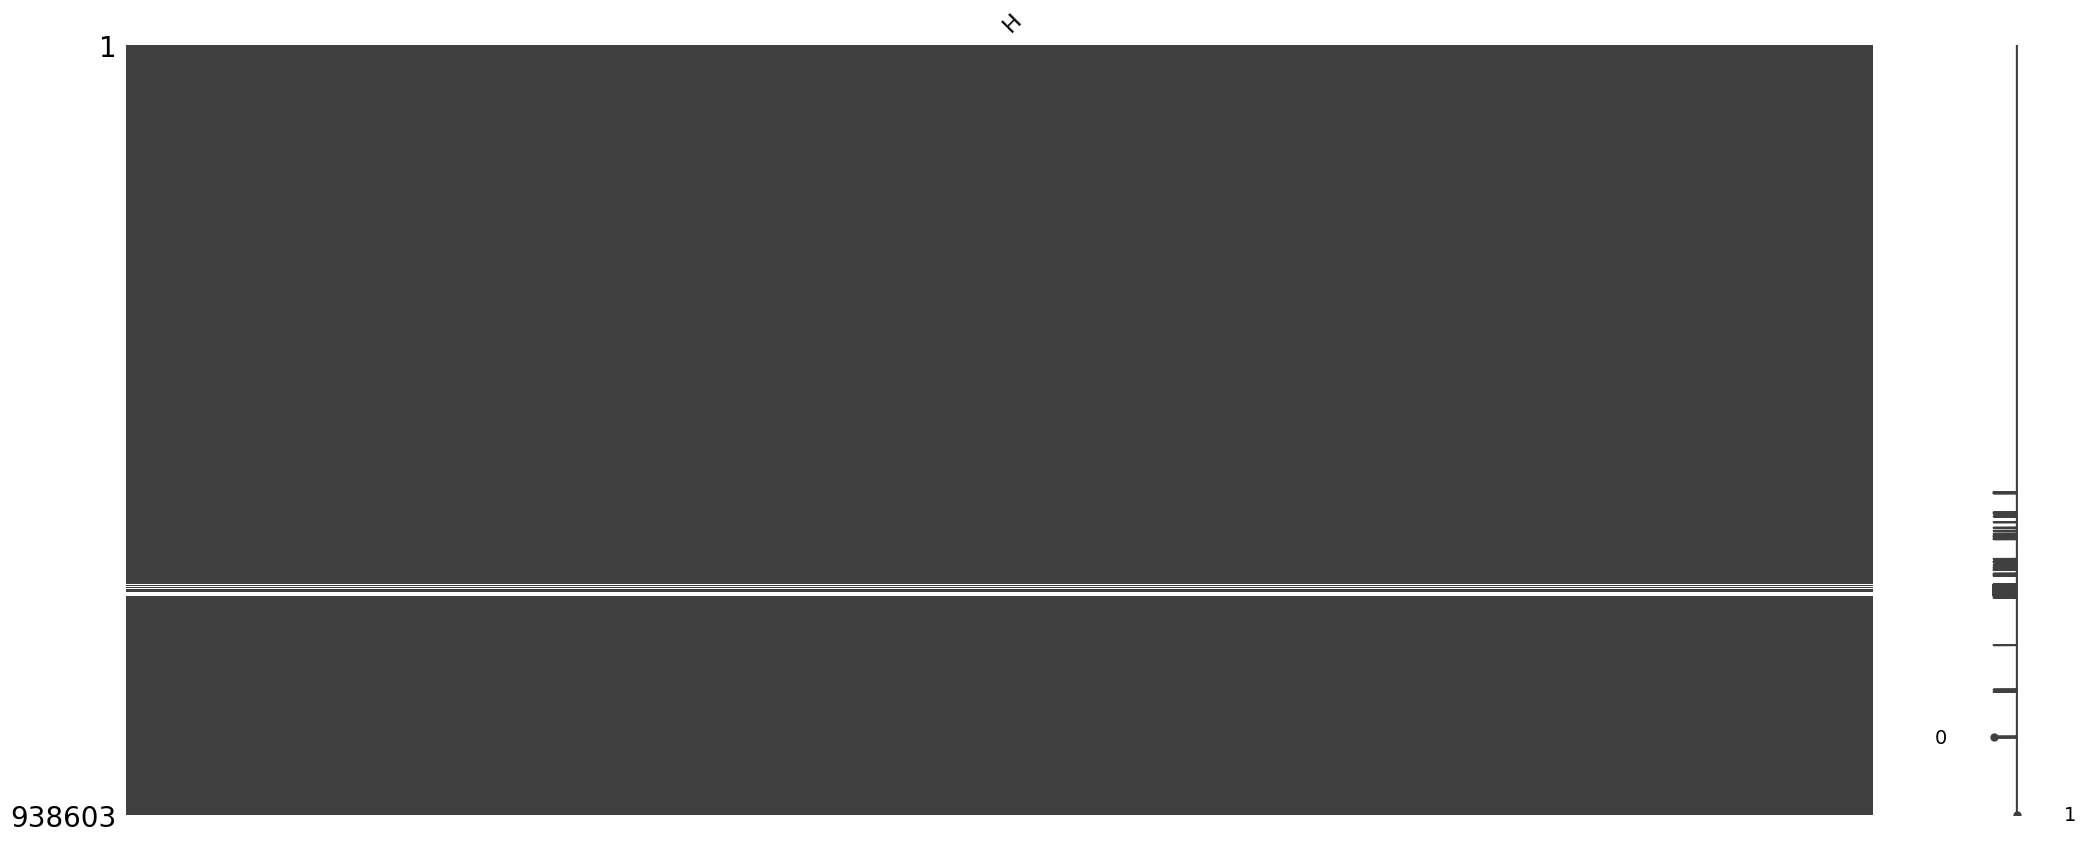

In [21]:
# Plotting the missing data matrix:
ms.matrix(df[['H']]);

Apparently, the missing data of the  H columns is not completely at random. So, we are going to imput them with the mean.

In [22]:
# Separete into two sets of data:
features = df.drop(columns='pha')
target = df['pha']

# Splitting the data:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Imputation of the missing data with the mean:
simpler_imputer = SimpleImputer(strategy='mean')
X_train['H'] = simpler_imputer.fit_transform(X_train[['H']])
X_test['H'] = simpler_imputer.transform(X_test[['H']])

For the rest of the missing data, we will drop them, because they were not systematically generated and because the number of missing data is not relevant compared with the amount of not missing data that we have.

In [23]:
# Dropping observations with missing data:
X_train['target'] = y_train
X_test['target'] = y_test

X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

In [24]:
# Training set with the same number of obsertions:
# Test set with the same number of observations:
y_train = X_train['target']
y_test = X_test['target']

X_train.drop(columns=['target'], inplace=True)
X_test.drop(columns=['target'], inplace=True)

- Equinox variable.

In [25]:
# Looking at the unique data of equinox column:
df['equinox'].unique()

array(['J2000'], dtype=object)

Equinox variable has just 1 type of data, so it is not important for the analysis.

In [26]:
# Dropping equinox column:
X_train.drop(columns=['equinox'], inplace=True)
X_test.drop(columns=['equinox'], inplace=True)

In [27]:
# Shape of the sets:
print(f"Traning Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")

Traning Shape: (750877, 31)
Test Shape: (187720, 31)


In [28]:
# Encoding the target variable:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [29]:
# Informations after Data Cleaning:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 750877 entries, ('bK14EF8X', '(2014 EX158)') to ('a0121959', '121959 (2000 EL67)')
Data columns (total 31 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   neo        750877 non-null  object 
 1   H          750877 non-null  float64
 2   epoch      750877 non-null  float64
 3   epoch_mjd  750877 non-null  int64  
 4   epoch_cal  750877 non-null  float64
 5   e          750877 non-null  float64
 6   a          750877 non-null  float64
 7   q          750877 non-null  float64
 8   i          750877 non-null  float64
 9   om         750877 non-null  float64
 10  w          750877 non-null  float64
 11  ma         750877 non-null  float64
 12  ad         750877 non-null  float64
 13  n          750877 non-null  float64
 14  tp         750877 non-null  float64
 15  tp_cal     750877 non-null  float64
 16  per        750877 non-null  float64
 17  per_y      750877 non-null  float64
 18  moid     

## 3) Exploratory Data Analysis

Some usefull functions.

In [30]:
# Function that calculates kurtosis and skewness of a dataset:
def kurtosis_skewness(dataset: any):
    col = ["Kurtosis", "Skewness"]
    results = pd.DataFrame(index=dataset.describe().columns, columns=col)
    for c in dataset.describe().columns:
        kurt = kurtosis(dataset[c])
        skewness = skew(dataset[c])
        results.loc[c] = [kurt, skewness]

    return results


# Heatmap of correlations:
def heatmap_cor(df: any):
    correlation = df.coRr()
    mask = np.zeros_like(correlation)
    mask[np.triu_indices_from(correlation)] = True
    sns.heatmap(correlation, mask=mask, annot=True, c="crest", cbar=True)


### 3.1) Descriptive Statistics

Let's see the descriptive statistics of the sigma columns.

In [31]:
# Statistical Summary:
sigma_list = [i for i in  X_train.columns if 'sigma' in i]
X_train[sigma_list].describe()

,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per
count,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05,7.508770e+05
mean,7.758346e-01,1.726028e+01,2.054308e+01,1.214982e+00,6.000012e+00,4.549929e+05,4.549157e+05,2.418465e+01,5.603977e-02,1.357960e+08,8.905039e+04
std,1.002947e+02,4.892992e+03,3.059394e+03,1.376154e+02,1.489532e+03,7.682747e+07,7.682117e+07,8.028341e+03,1.096641e+01,2.309041e+10,2.947131e+07
min,1.285600e-10,4.145500e-11,2.616800e-10,4.087800e-08,2.163900e-07,1.789300e-07,2.103800e-07,5.572900e-11,2.860900e-11,3.088400e-07,2.335200e-08
25%,5.477000e-08,2.046300e-08,1.462100e-07,6.094500e-06,3.622600e-05,5.759500e-05,2.573700e-05,2.340400e-08,2.768800e-09,1.110900e-04,1.793700e-05
50%,8.167200e-08,3.850300e-08,2.271700e-07,8.687700e-06,6.650600e-05,1.047800e-04,4.900800e-05,4.361800e-08,4.637100e-09,2.231400e-04,3.500700e-05
75%,2.338800e-07,1.044500e-07,6.595600e-07,1.591900e-05,1.613200e-04,3.118800e-04,1.719500e-04,1.196900e-07,1.125300e-08,8.145700e-04,9.779100e-05
max,3.942500e+04,3.241200e+06,1.015000e+06,5.533000e+04,1.199100e+06,3.340000e+10,3.339300e+10,5.509700e+06,7.698800e+03,1.041500e+13,1.910700e+10


Observations:

- All of the sigma columns are positive and have enormous ranges of values.
- All of the sigma columns have Outliers.
- Sigma_tp has the biggest standard deviantion and also the biggest max value.

Now let's dive a little bit into the Absolute magnitude parameter (H), epoch, epoch_mjd, epoch_cal, Eccentricity (e), Semi-major axis (a), Perihelion distance (q) and Inclination (i) columns.

In [32]:
# Selecting columns:
initial_columns = ['H', 'epoch', 'epoch_mjd', 'epoch_cal', 'e', 'a', 'q', 'i']

# Descriptive Statistic of the initial numeric columns:
X_train[initial_columns].describe()

,H,epoch,epoch_mjd,epoch_cal,e,a,q,i
count,750877.000000,7.508770e+05,750877.000000,7.508770e+05,750877.000000,750877.000000,750877.000000,750877.000000
mean,16.890408,2.458871e+06,58870.829587,2.019698e+07,0.156175,2.900448,2.397450,9.044674
std,1.795913,7.055785e+02,705.578515,1.940802e+04,0.092974,12.327240,2.157830,6.658707
min,-1.100000,2.425052e+06,25051.000000,1.927062e+07,0.000003,0.555418,0.075872,0.007744
25%,16.000000,2.459000e+06,59000.000000,2.020053e+07,0.092078,2.388185,1.971846,4.152227
50%,16.900000,2.459000e+06,59000.000000,2.020053e+07,0.144916,2.647204,2.226284,7.398350
75%,17.700000,2.459000e+06,59000.000000,2.020053e+07,0.200694,3.002401,2.579520,12.390983
max,33.200000,2.459000e+06,59000.000000,2.020053e+07,0.999591,8850.823836,80.398819,175.082901


Observations:

- Negative values in the Absolute magnitude parameter (H).
- There are some Outliers in Eccentricity (e), Semi-major axis (a), Perihelion distance (q), Inclination (i) and Absolute magnitude parameter (H).

Finally, let's see the rest of the numeric columns.

In [33]:
# Selecting columns:
other_columns = ['om', 'w', 'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid']

# Descriptive Statistic of the other numeric columns:
X_train[other_columns].describe()

,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid
count,750877.000000,750877.000000,750877.000000,750877.000000,750877.000000,7.508770e+05,7.508770e+05,7.508770e+05,750877.000000,7.508770e+05
mean,168.500688,181.376168,177.210988,3.403445,0.236686,2.458858e+06,2.019585e+07,2.900275e+03,7.940519,1.414834e+00
std,102.886239,103.885218,105.869845,24.216581,0.079762,1.600272e+03,4.391532e+04,3.635303e+05,995.291634,2.155184e+00
min,0.000025,0.000130,-67.136826,0.653773,0.000001,2.283183e+06,1.539011e+07,1.511918e+02,0.413941,4.544120e-07
25%,80.610134,91.541555,83.600824,2.781923,0.189453,2.458564e+06,2.019032e+07,1.348032e+03,3.690711,9.797690e-01
50%,159.947331,182.275912,175.284210,3.047334,0.228835,2.458946e+06,2.020041e+07,1.573184e+03,4.307143,1.240520e+00
75%,252.248318,271.571677,269.886957,3.365602,0.267056,2.459362e+06,2.021053e+07,1.900209e+03,5.202490,1.593080e+00
max,359.999793,359.998075,491.618014,17698.024949,2.381082,2.546362e+06,2.259081e+07,3.041403e+08,832690.763699,7.947660e+01


Observations:

- Longitude of the ascending node (om) , Argument of perihelium (w) have similar distributions.
- Mean Anomaly has negative values.
- The Earth Minimum Orbit Intersection Distance (moid) is 4.544120e-07 Astronomical Units.

### 3.2) Distributions and Correlations

Now, let's look at the distribution and compute the Kurtosis and Skewness of the sigma columns. We will change the scale of the variables to a logarithmic scale due to their range, otherwise the plots won't look good and, we won't be able to interpret the results.

#### 3.2.1) Histograms, Kurtosis and Skewness

In [34]:
# Changing the scale of the data:
new_name = ['log_' + i for i in sigma_list]
dictionary = dict(zip(sigma_list, new_name))
log_data = np.log(X_train[sigma_list])
log_data.rename(columns=dictionary, inplace=True)

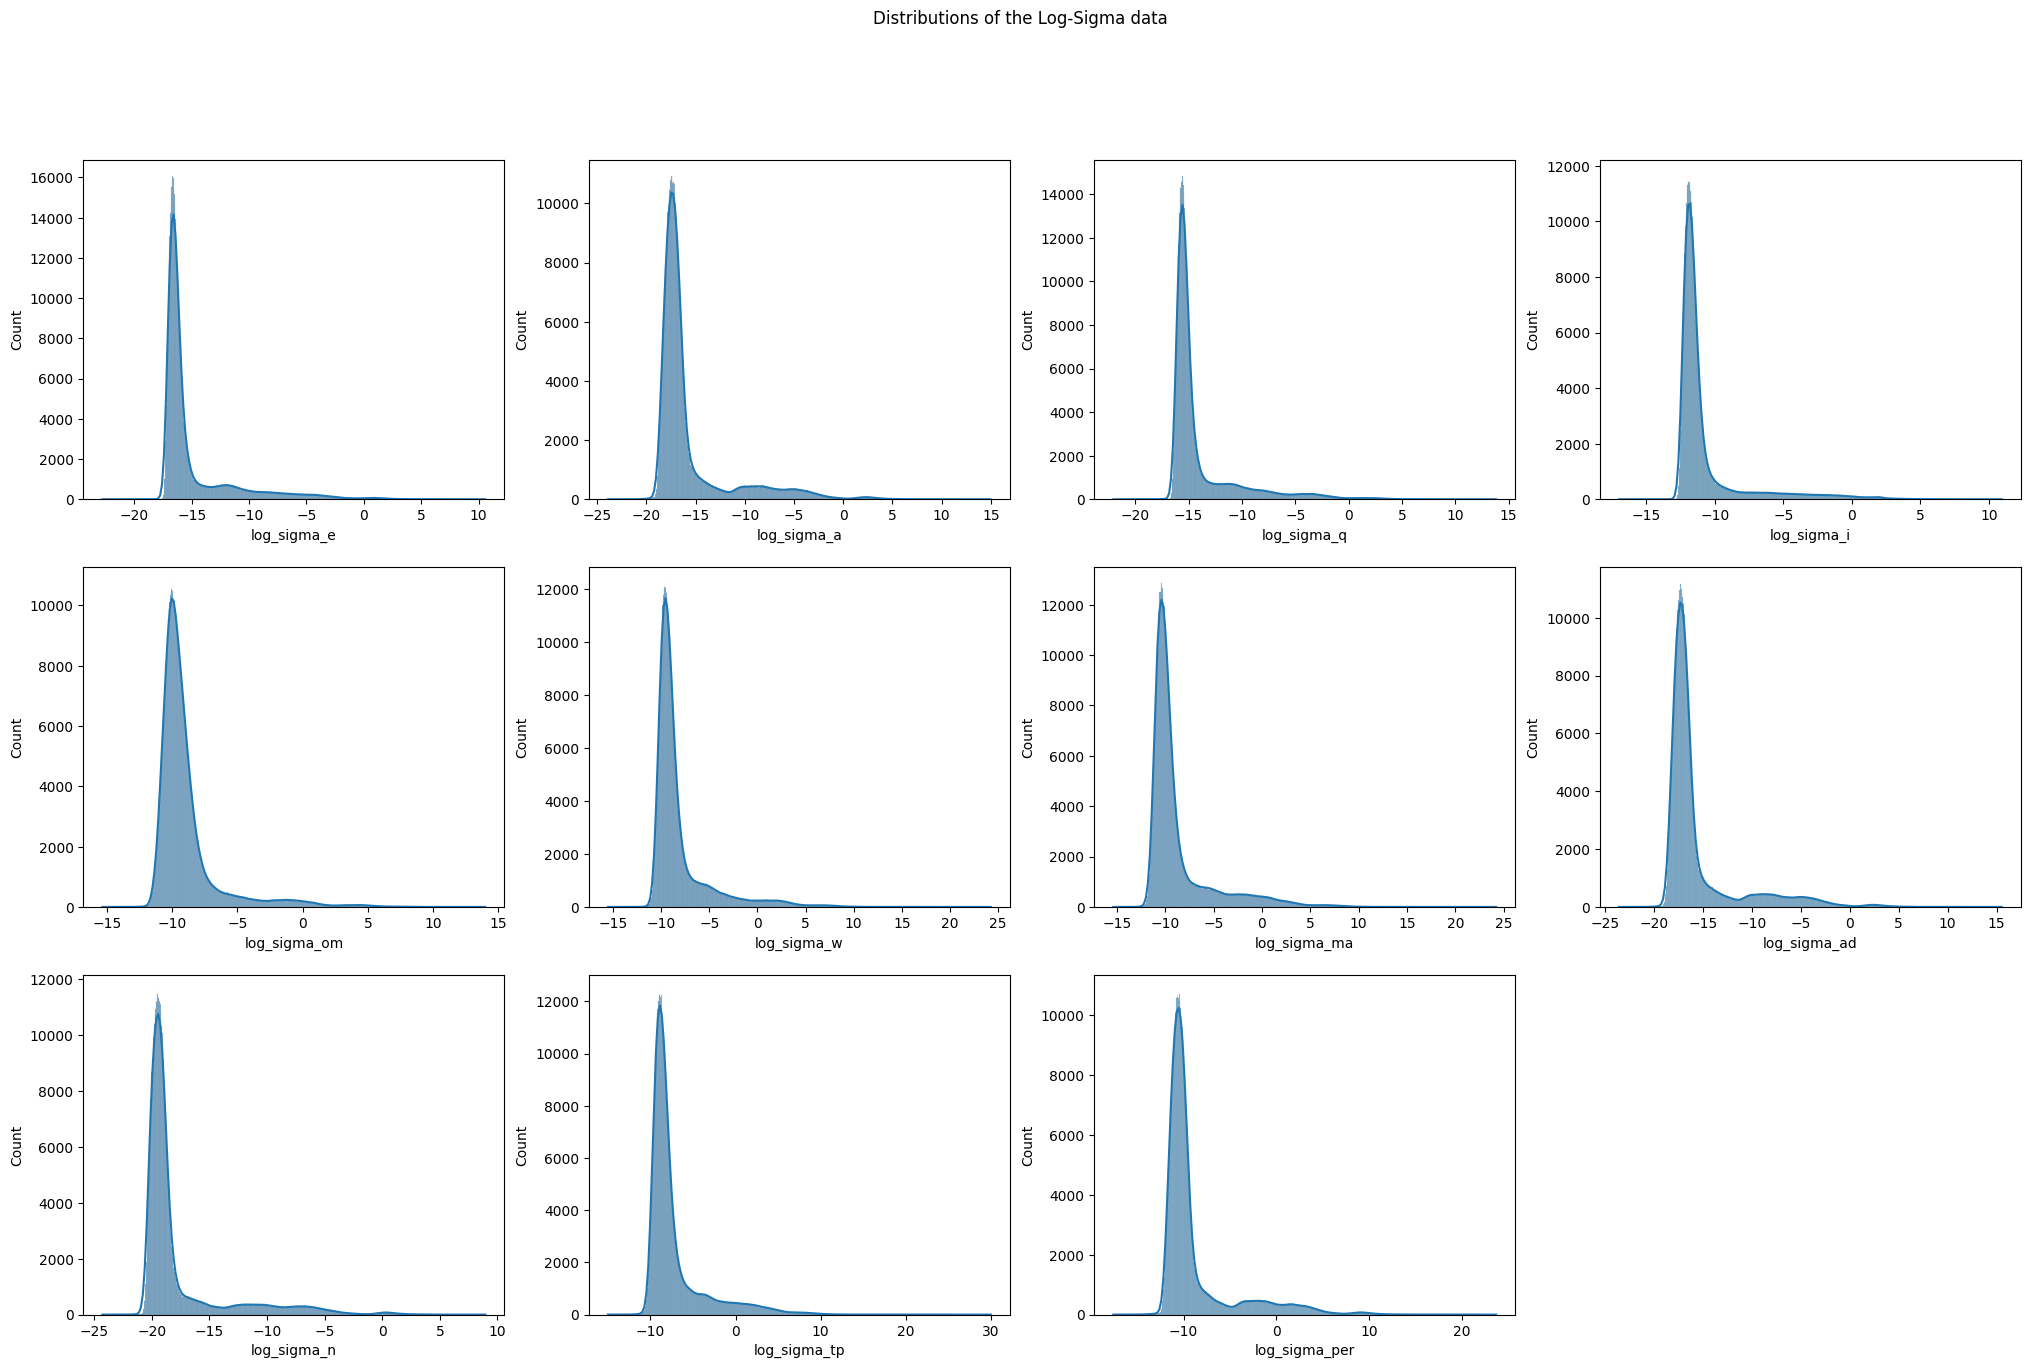

In [35]:
# Creating a subplot:
fig, ax = plt.subplots(nrows= 3, ncols=4, sharex=False, sharey=False, figsize=(25, 15))
fig.suptitle("Distributions of the Log-Sigma data")

# Histogram plots:
sns.histplot(log_data['log_sigma_e'], ax=ax[0, 0], kde=True)
sns.histplot(log_data['log_sigma_a'], ax=ax[0, 1], kde=True)
sns.histplot(log_data['log_sigma_q'], ax=ax[0, 2], kde=True)
sns.histplot(log_data['log_sigma_i'], ax=ax[0, 3], kde=True)
sns.histplot(log_data['log_sigma_om'], ax=ax[1, 0], kde=True)
sns.histplot(log_data['log_sigma_w'], ax=ax[1, 1], kde=True)
sns.histplot(log_data['log_sigma_ma'], ax=ax[1, 2], kde=True)
sns.histplot(log_data['log_sigma_ad'], ax=ax[1, 3], kde=True)
sns.histplot(log_data['log_sigma_n'], ax=ax[2, 0], kde=True)
sns.histplot(log_data['log_sigma_tp'], ax=ax[2, 1], kde=True)
sns.histplot(log_data['log_sigma_per'], ax=ax[2, 2], kde=True)

ax[2, 3].set_visible(False)

In [36]:
# Printing Kurtosis and Skewness for the log(sigma) columns:
kurtosis_skewness(log_data)

,Kurtosis,Skewness
log_sigma_e,6.204082,2.475314
log_sigma_a,5.646046,2.400785
log_sigma_q,6.867976,2.552479
log_sigma_i,8.351038,2.880583
log_sigma_om,10.566405,2.981978
log_sigma_w,8.715659,2.724005
log_sigma_ma,6.282922,2.400544
log_sigma_ad,5.587056,2.39486
log_sigma_n,5.49624,2.421342
log_sigma_tp,7.331019,2.48295


Observations:

- Log-Sigma features are hightly right skewed and definitely not follow normal distribution.
- All of the distributions are Leptokurtic because the Kurtosis is greater than three.

Let's see the distributions of Absolute magnitude parameter (H), epoch, epoch_mjd, epoch_cal, Eccentricity (e), Semi-major axis (a), Perihelion distance (q) and Inclination (i) columns.

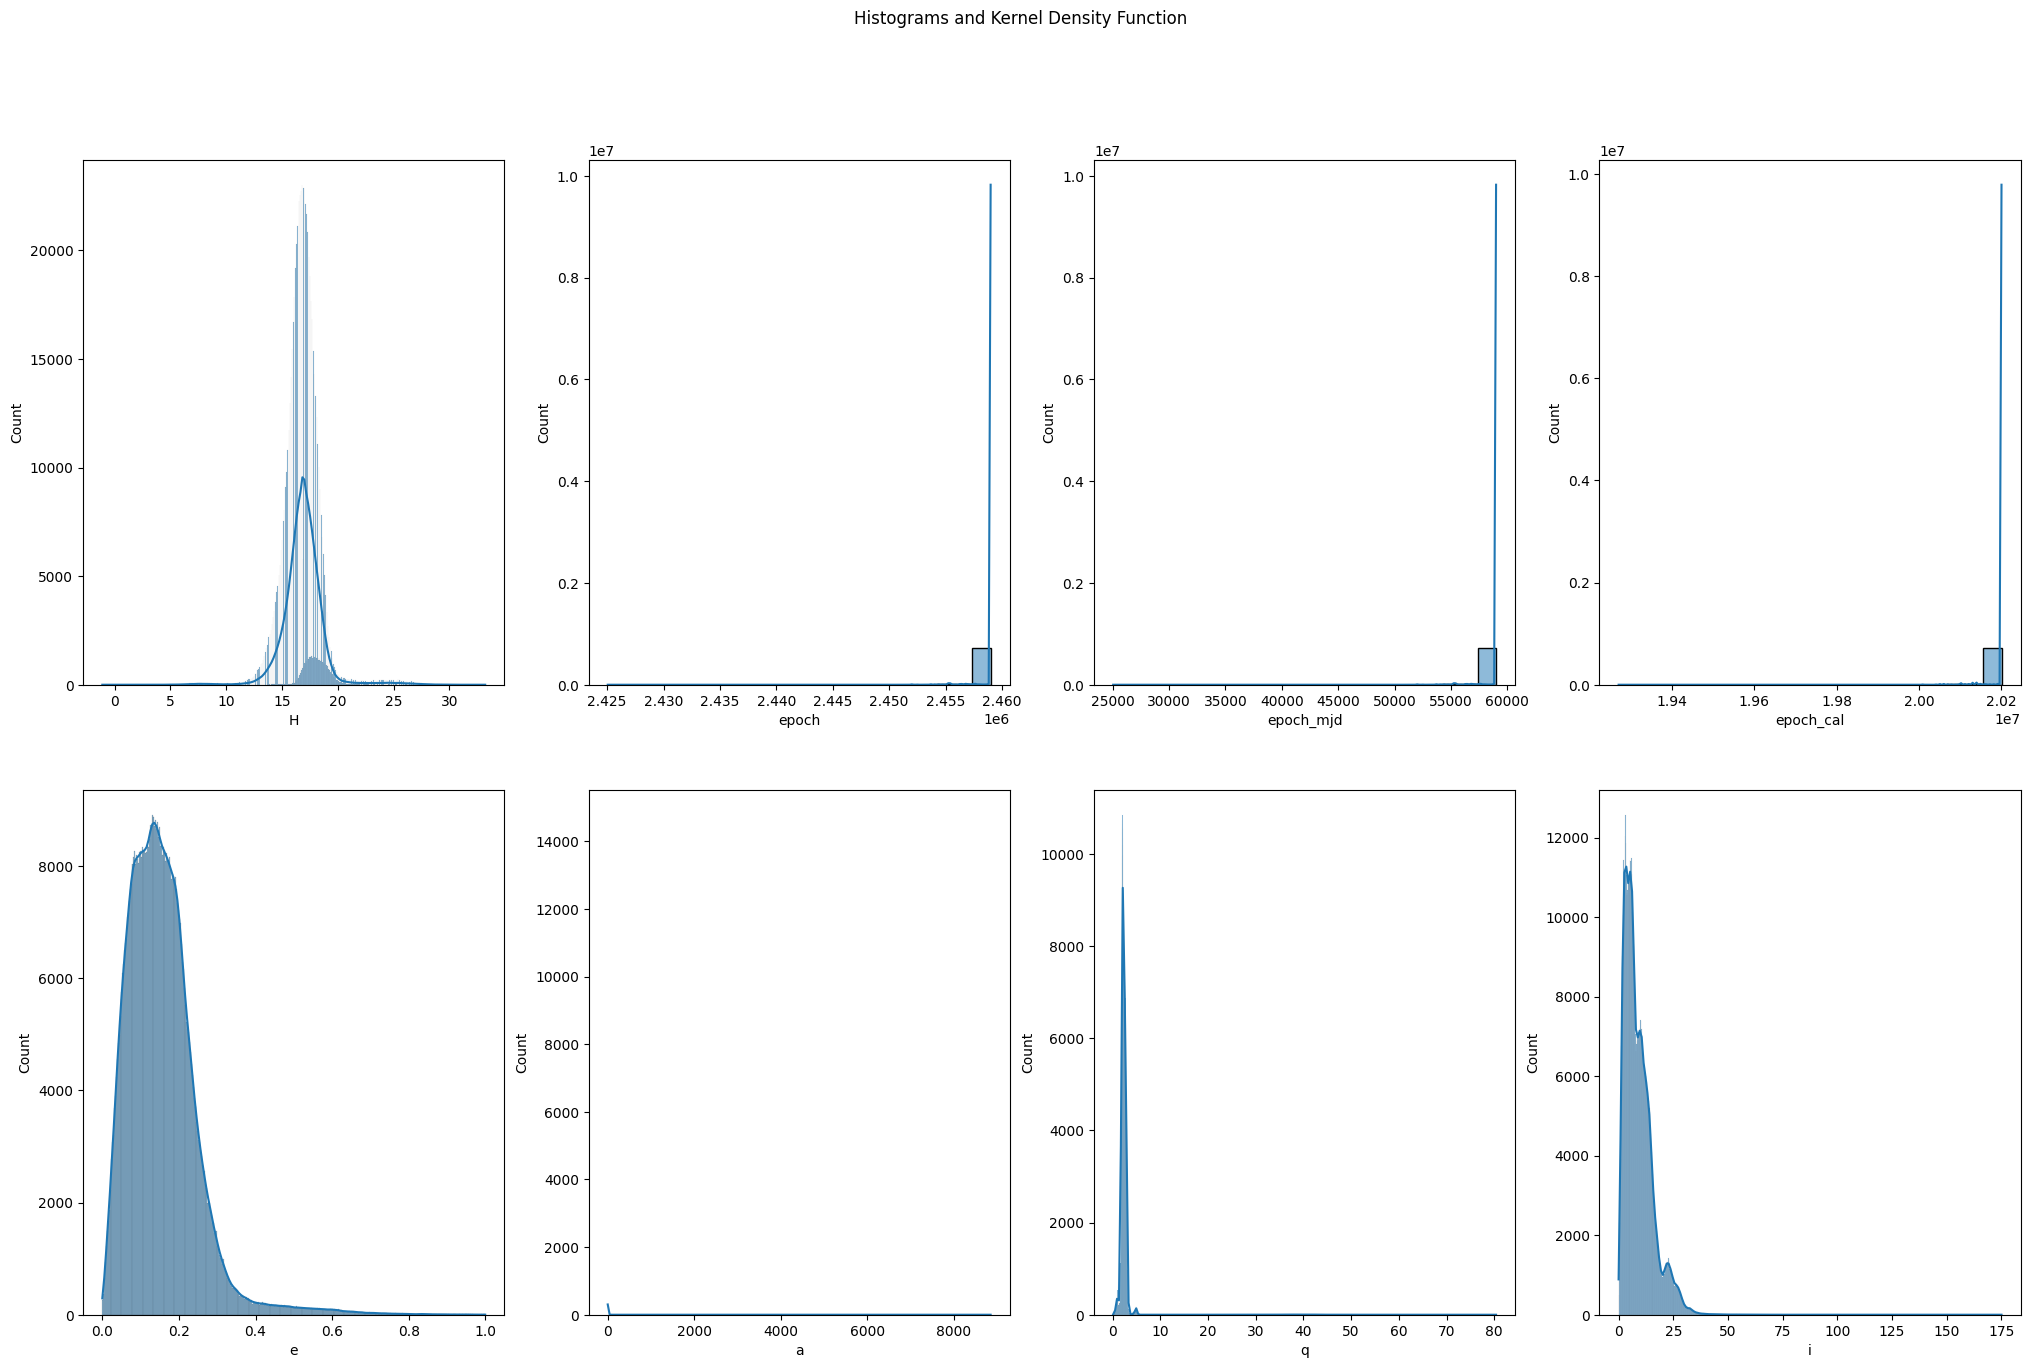

In [37]:
# Creating a subplot:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex=False, sharey=False, figsize=(25, 15))
fig.suptitle("Histograms and Kernel Density Function")

# Histogram plots:
sns.histplot(X_train['H'], ax=ax[0, 0], kde=True)
sns.histplot(X_train['epoch'], ax=ax[0, 1], kde=True)
sns.histplot(X_train['epoch_mjd'], ax=ax[0, 2], kde=True)
sns.histplot(X_train['epoch_cal'], ax=ax[0, 3], kde=True)
sns.histplot(X_train['e'], ax=ax[1, 0], kde=True)
sns.histplot(X_train['a'], ax=ax[1, 1], kde=True)
sns.histplot(X_train['q'], ax=ax[1, 2], kde=True)
sns.histplot(X_train['i'], ax=ax[1, 3], kde=True);


In [38]:
# Printing Kurtosis and Skewness for the initial columns:
kurtosis_skewness(X_train[initial_columns])

,Kurtosis,Skewness
H,9.574231,0.632873
epoch,63.509785,-6.773483
epoch_mjd,63.509785,-6.773483
epoch_cal,63.507964,-6.778353
e,7.807368,1.900893
a,359883.099936,528.109344
q,264.636904,15.725018
i,22.503049,2.266021


Observations:

- None of them look normally distributed.
- Distribution of Epoch, Epoch_mjd and Epoch_cal are quite similar and have a large range of values.
- Eccentricity's distribution is right skewed as we can see on the Histogram and with the Skeweness above 1.
- Semi-major axis (a) is has a wide range of values and the majority of them lies between 0 and 5. It is also a Leptokurtic distribution due to its hight value of Kurtosis, which means this distributions tend to produce more outliers than the normal distribution.

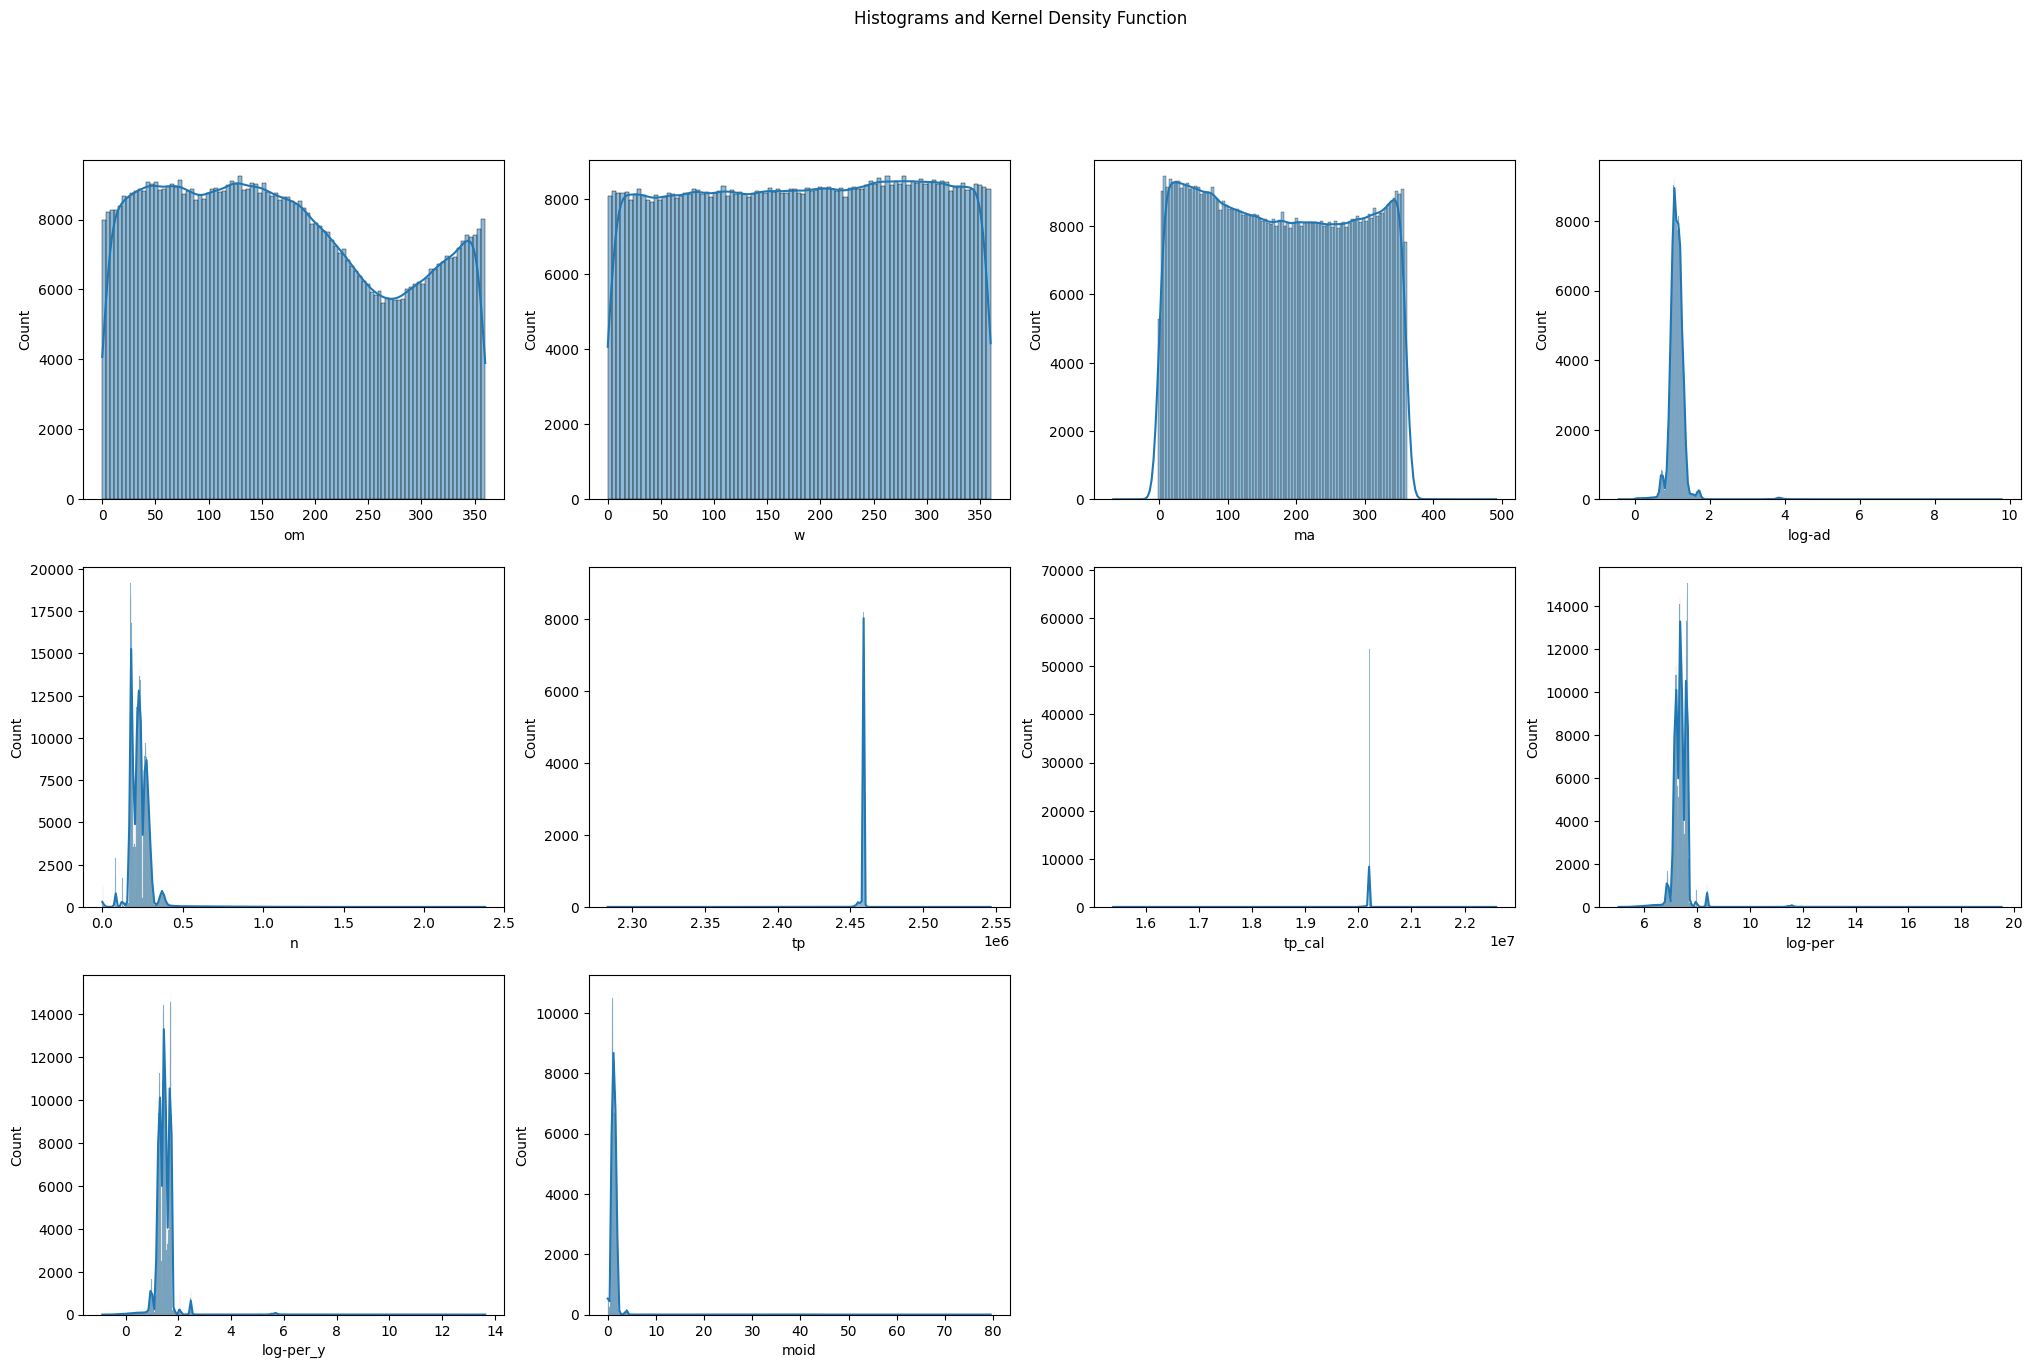

In [39]:
# Creating a subplot:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=False, sharey=False, figsize=(25, 15))
fig.suptitle("Histograms and Kernel Density Function")

# Histogram plots:
sns.histplot(X_train['om'], ax=ax[0, 0], kde=True)
sns.histplot(X_train['w'], ax=ax[0, 1], kde=True)
sns.histplot(X_train['ma'], ax=ax[0, 2], kde=True)

sns.histplot(np.log(X_train['ad']), ax=ax[0, 3], kde=True)
ax[0, 3].set_xlabel('log-ad')

sns.histplot(X_train['n'], ax=ax[1, 0], kde=True)
sns.histplot(X_train['tp'], ax=ax[1, 1], kde=True)
sns.histplot(X_train['tp_cal'], ax=ax[1, 2], kde=True)

sns.histplot(np.log(X_train['per']), ax=ax[1, 3], kde=True)
ax[1, 3].set_xlabel('log-per')

sns.histplot(np.log(X_train['per_y']), ax=ax[2, 0], kde=True)
ax[2, 0].set_xlabel('log-per_y')

sns.histplot(X_train['moid'], ax=ax[2, 1], kde=True)

ax[2, 2].set_visible(False)
ax[2, 3].set_visible(False);

In [40]:
# Printing Kurtosis and Skewness for the other columns:
kurtosis_skewness(X_train[other_columns])

,Kurtosis,Skewness
om,-1.108926,0.196737
w,-1.20069,-0.019961
ma,-1.233766,0.043606
ad,386475.66126,556.60062
n,63.992398,5.635289
tp,739.249481,-4.714999
tp_cal,731.590956,-4.676611
per,653535.966944,787.456975
per_y,653535.966944,787.456975
moid,265.866793,15.782915


Observations:

- There is a few asteroids with Longitude of the ascending node (om) near 260º.
- Argument of perihelium (w) column seems to follow a continuous uniform distribution.

#### 3.2.2) Boxplots

Now, let's see the distribution and the outliers of the variables using boxplot.

In [41]:
df_train = X_train.copy()
df_train['Target'] = y_train

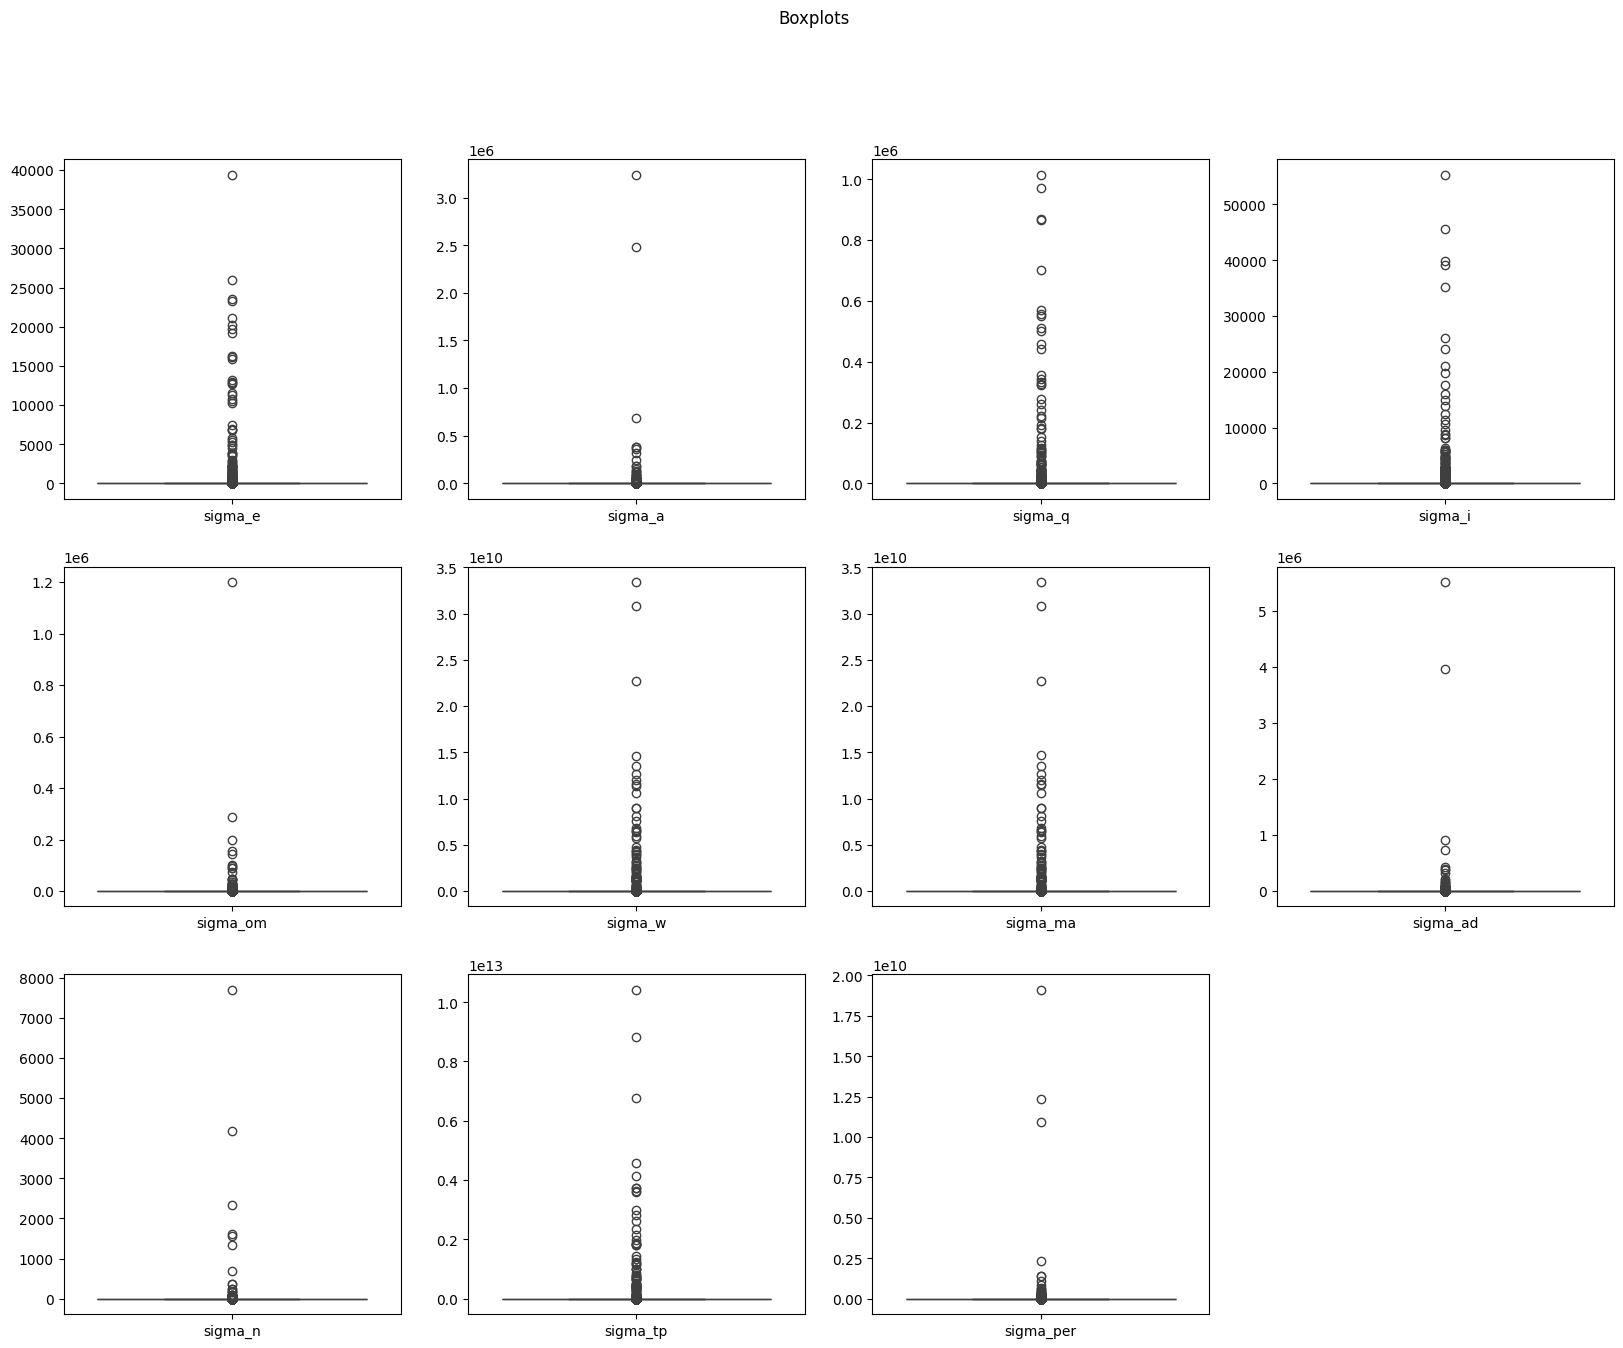

In [42]:
# Boxplots of the sigma variables:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=False, sharey=False, figsize=(20, 15))
fig.suptitle("Boxplots")

sns.boxplot(X_train[['sigma_e']], ax=ax[0, 0])
sns.boxplot(X_train[['sigma_a']], ax=ax[0, 1])
sns.boxplot(X_train[['sigma_q']], ax=ax[0, 2])
sns.boxplot(X_train[['sigma_i']], ax=ax[0, 3])
sns.boxplot(X_train[['sigma_om']], ax=ax[1, 0])
sns.boxplot(X_train[['sigma_w']], ax=ax[1, 1])
sns.boxplot(X_train[['sigma_ma']], ax=ax[1, 2])
sns.boxplot(X_train[['sigma_ad']], ax=ax[1, 3])
sns.boxplot(X_train[['sigma_n']], ax=ax[2, 0])
sns.boxplot(X_train[['sigma_tp']], ax=ax[2, 1])
sns.boxplot(X_train[['sigma_per']], ax=ax[2, 2])

ax[2, 3].set_visible(False)

Observations:
- All of sigma columns have outliers.
- The plot of the boxplot is represented as a line because of the magnitude of the outliers.

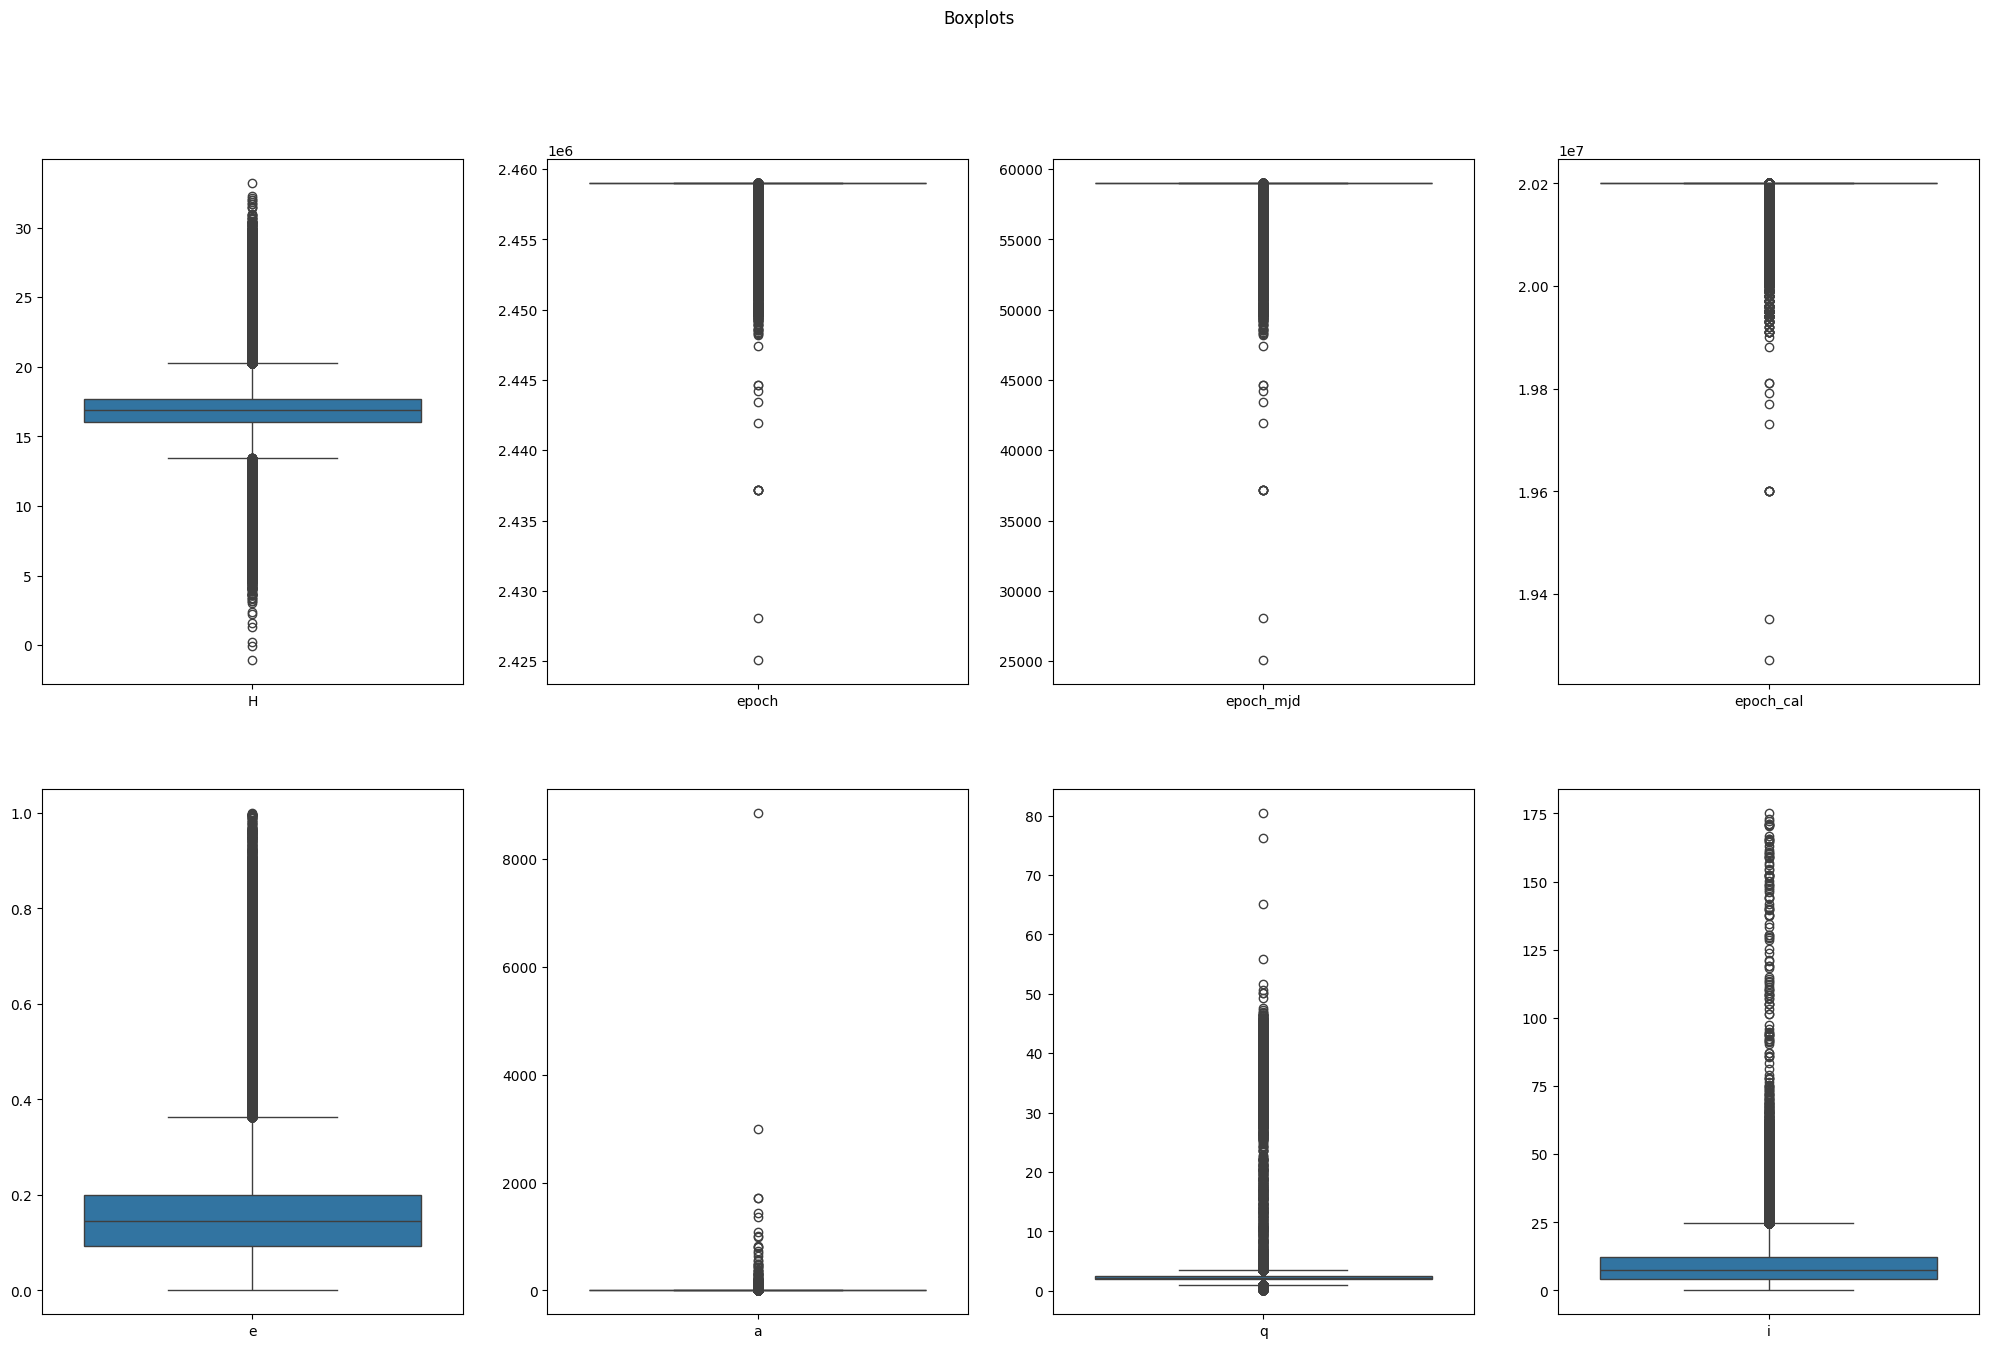

In [43]:
# Boxplot of the first set of columns:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex=False, sharey=False, figsize=(25, 15))
fig.suptitle("Boxplots")

sns.boxplot(X_train[['H']], ax=ax[0, 0])
sns.boxplot(X_train[['epoch']], ax=ax[0, 1])
sns.boxplot(X_train[['epoch_mjd']], ax=ax[0, 2])
sns.boxplot(X_train[['epoch_cal']], ax=ax[0, 3])
sns.boxplot(X_train[['e']], ax=ax[1, 0])
sns.boxplot(X_train[['a']], ax=ax[1, 1])
sns.boxplot(X_train[['q']], ax=ax[1, 2])
sns.boxplot(X_train[['i']], ax=ax[1, 3]);

Observations:
- Absolute magnitude parameter (H) has low standard deviation due to the IQR.
- Some asteroids have eccentricity close to one and are considered as Outliers.

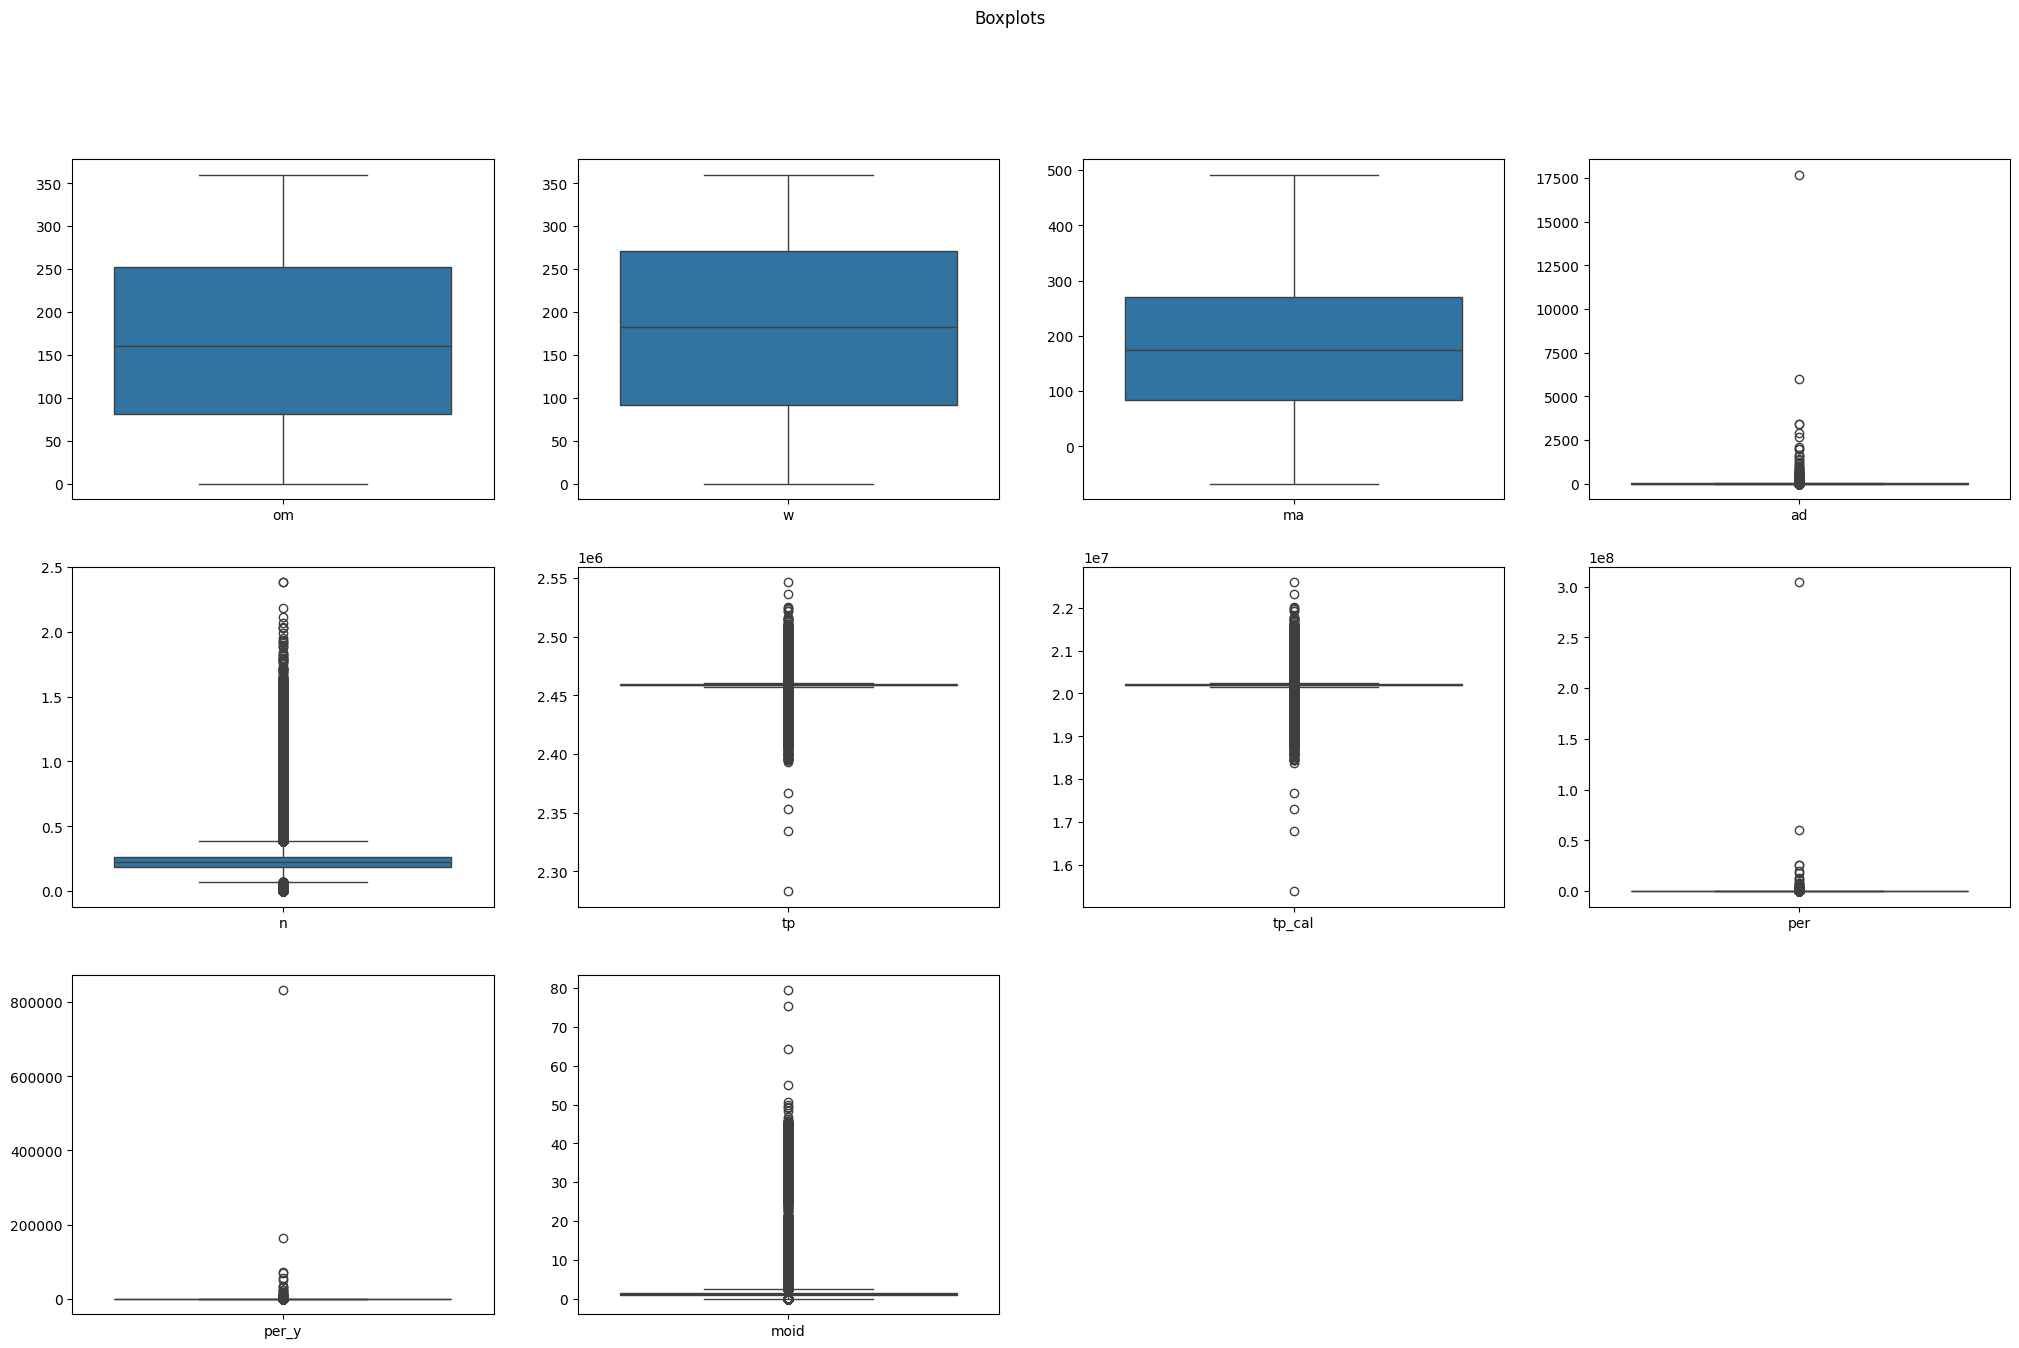

In [44]:
# Boxplot of the rest of the columns:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=False, sharey=False, figsize=(25, 15))
fig.suptitle("Boxplots")

sns.boxplot(X_train[['om']], ax=ax[0, 0])
sns.boxplot(X_train[['w']], ax=ax[0, 1])
sns.boxplot(X_train[['ma']], ax=ax[0, 2])
sns.boxplot(X_train[['ad']], ax=ax[0, 3])
sns.boxplot(X_train[['n']], ax=ax[1, 0])
sns.boxplot(X_train[['tp']], ax=ax[1, 1])
sns.boxplot(X_train[['tp_cal']], ax=ax[1, 2])
sns.boxplot(X_train[['per']], ax=ax[1, 3])
sns.boxplot(X_train[['per_y']], ax=ax[2, 0])
sns.boxplot(X_train[['moid']], ax=ax[2, 1])

ax[2, 2].set_visible(False)
ax[2, 3].set_visible(False);

Observations:
- Longitude of the ascending node (om), Argument of perihelium (w), Mean Anomaly (ma) have no Outliers and have a simuliar distribution due to the nature of the variables.

#### 3.2.3) Correlations

In [45]:
def mann_whitney_func(features, target, numeric_columns):
    statistics = []
    p_values = []

    group1 = features[target==1]
    group2 = features[target==0]

    for feature in numeric_columns:
        statistic, p_value = mannwhitneyu(group1[feature].values, group2[feature].values)
        statistics.append(statistic)
        p_values.append(p_value)

    dicionario = dict(Mann_Whitney_U=statistics, P_value=p_values)
    df_pt = pd.DataFrame(index=numeric_columns, data=dicionario)
    return df_pt



def ch2_func(features, target):
    cat_columns = features.columns
    statistics = []
    p_values = []

    for feature in cat_columns:
        # Creating a contingency table:
        df_contingency = pd.crosstab(features[feature], target)

        # Chi squared:
        statistic, p_value, dof, expected = chi2_contingency(df_contingency)

        statistics.append(statistic)
        p_values.append(p_value)

    dicionario = dict(Chi_Squared=statistics, P_value=p_values)
    df_ch = pd.DataFrame(index=cat_columns, data=dicionario)
    return df_ch

##### 3.2.3.1) Numerical Independent Variables

As our target variable is categorical, we can use some methods to check if there is relation between numerical features and the dependent variables. However, all our numerical features do not follow a normal distriution, so we have to choose a Non-Parametric test to evaluate if are difference between groups. One approach is to use the Mann Whitney U test, which is statitical test that evaluates if there is a satistically diference between two independent groups.

- Mann Whitney U

H0: Groups came from the same Distribution.

H1: Groups came from different Distributions.

significance level = 0.05

In [46]:
# Selecting the numerical columns:
numeric_columns = sigma_list + initial_columns + other_columns

# Computing the Mann Whitney U test:
df_mw = mann_whitney_func(X_train, y_train, numeric_columns)
df_mw

,Mann_Whitney_U,P_value
sigma_e,6.639186e+08,1.602131e-08
sigma_a,5.426100e+08,2.738368e-16
sigma_q,5.122688e+08,2.445461e-31
sigma_i,7.887824e+08,4.939480e-88
sigma_om,5.296364e+08,4.292388e-22
sigma_w,4.691271e+08,1.254976e-61
sigma_ma,5.757771e+08,1.073567e-05
sigma_ad,5.842754e+08,5.977712e-04
sigma_n,7.636538e+08,5.404597e-65
sigma_tp,4.356460e+08,2.367745e-92


Observations:
- Longitude of the ascending node (om) has a p-value higher than the significance level, so there is no evidence to reject the Null Hyothesis that there is no difference between groups.

- Argument of perihelium (w) has a p-value higher than the significance level, so there is no evidence to reject the Null Hyothesis that there is no difference between groups.

- Time of perihelion passage (tp) has a p-value higher than the significance level, so there is no evidence to reject the Null Hyothesis that there is no difference between groups.

- Time of perihelion passage (Apparently, calibrated) (tp_cap) has a p-value higher than the significance level, so there is no evidence to reject the Null Hyothesis that there is no difference between groups.

##### 3.2.3.1) Categorical Independent Variables

- Chi Squared

For the categorical independent features, we can apply the Chi Squared test to verify if two categorical variables have any relationship. This test is a non-parametric test and so is less likely to reject the null hypothesis, epecially when it is false.

H0: The proportion of each group is not independent. So it was not drew from the same distribution.

H1: The proportion of each groups is independent and were drew from diferent distributions.

significance level: 0.05

In [47]:
# Selecting the categorical columns:
categorical_columns = ['class', 'neo']

# Applying ch2 function:
df_ch = ch2_func(X_train[categorical_columns], y_train)
df_ch

,Chi_Squared,P_value
class,95044.341663,0.0
neo,65713.810916,0.0


Observations:

- Since p-value for both attributes are below the significance level of 0.05, we can reject the null Hypothesis that both of them are not related to the target attribute.

### 3.3) Exploring the Variables

In [48]:
# Dataframe for analysis:
df_train = X_train.copy()
df_train['Target'] = y_train

#### Eccentricity

The eccentricity of a Orbit is a metric that quantify the shape of the Orbit, and can be a real number greater or equal to zero.

- Eccentricity equals to zero: Circular Orbit.
- Eccentricity between zero and one: Elliptical Orbit.
- Eccentricity equals to one: Parabolic Obit.
- Eccentricity greater than one: Hyperbolic Orbit.

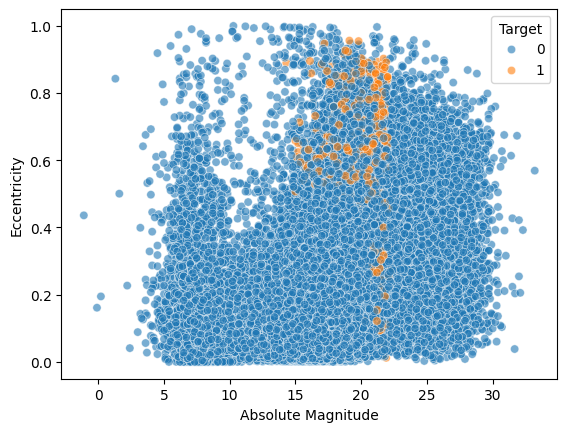

In [49]:
# Absolute Magnitude vs Eccentricity:
sns.scatterplot(x=df_train['H'], y=df_train['e'], hue=df_train['Target'], alpha=0.6)
plt.ylabel("Eccentricity")
plt.xlabel("Absolute Magnitude")
plt.show()

Observations:

- It is very difficult to see something on this plot, maybe we should explore these variables in a different way.

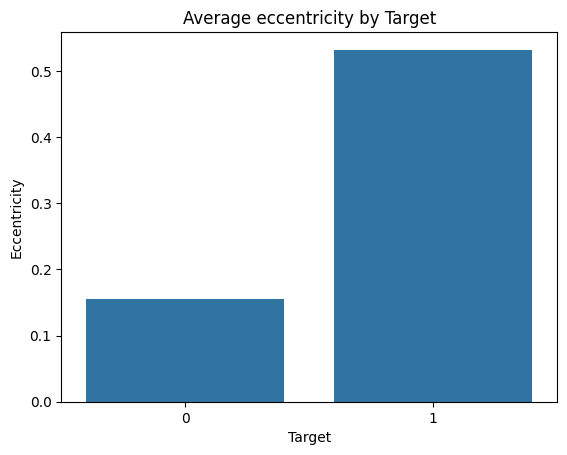

In [50]:
# Plotting the difference bewteen the average eccentricity by target class:
group = df_train.groupby('Target').agg({'e':'mean'}).reset_index()
sns.barplot(y=group['e'], x=group['Target'])
plt.title("Average eccentricity by Target")
plt.ylabel("Eccentricity")
plt.show()

Observations:

- The average of eccentricity for potentially dangerous asteroids is much higher.
- the Eccentricity between zero and one means elliptical Orbit and, the closer this measures get to one, the more parabolic it becomes.


#### NEO: Near-Earth Object (NEO) flag

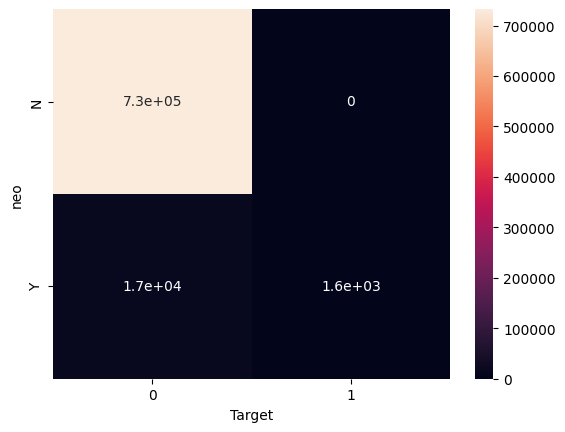

In [51]:
# Plotting Near-Earth Object vs Class as a contigency table:
cross = pd.crosstab(df_train['neo'], df_train['Target'])
sns.heatmap(cross, annot=True, cmap=None, cbar=True)
plt.show()

Observations:

- As we can see above, all of the potentially dangerous Asteroids are near the earth.
- Majority of the non dangerous Asteroids are not close to the earth.

#### Orbit class

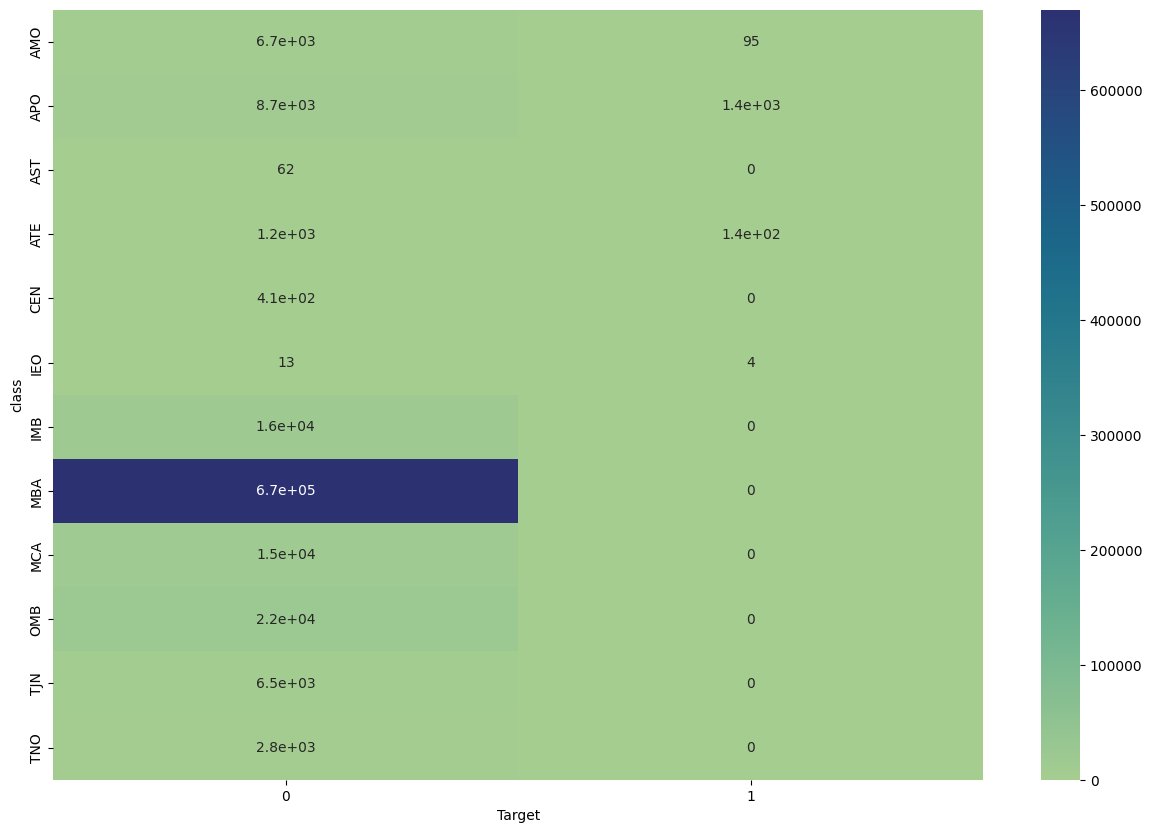

In [52]:
# Contingency table of class and the target:
cross = pd.crosstab(df_train['class'], df_train['Target'])
plt.figure(figsize=(15, 10))
sns.heatmap(cross, cbar=True, annot=True, cmap='crest')
plt.show()

Observations:

- Majority of the potentially dangerous Asteroids are classified in the APO class.
- Most of the non dengerous Asteroids are associated with the class MBA.

#### Aphelium distance and Perihelium distance

Aphelium distance: The Aphelium distance is the farthest point of a object's orbit around a celestial body.

Perihelium distance: The Perihelium distance is the closest point of a object's orbit around a celestial body.

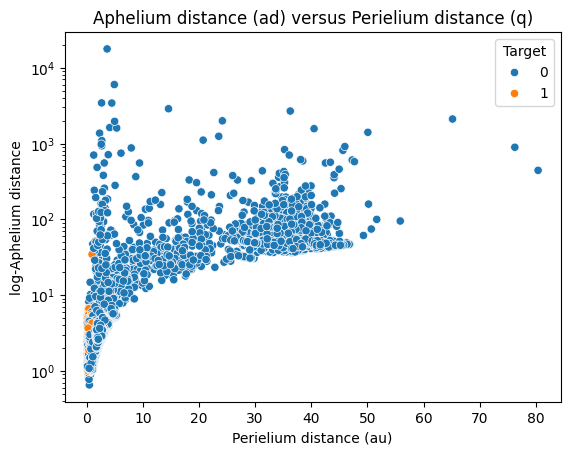

In [53]:
# Looking into the Aphelium distance (ad) and the Perielium distance (q):
sns.scatterplot(y=df_train['ad'], x=df_train['q'], hue=df_train['Target'])
plt.title("Aphelium distance (ad) versus Perielium distance (q)")
plt.yscale("log") # Setting the y axis as a log scale axis
plt.xlabel("Perielium distance (au)")
plt.ylabel("log-Aphelium distance")
plt.show()

Observations:

- All of the dangerous Asteroids have low Perielium distance compared to the non dangerous ones. This means that their closest part of their Orbit around the sun is lower them the majorit of the other Asteroids.

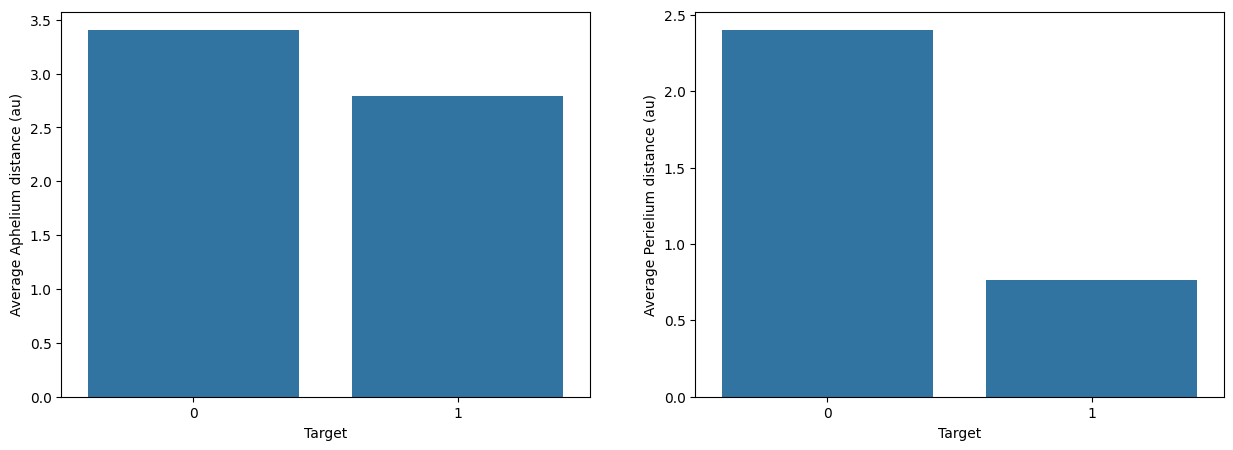

In [54]:
# Aphelium and Perihelium distance by target class:
group = df_train.groupby('Target').agg({'ad':'mean', 'q':'mean'}).reset_index()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5), sharex=False, sharey=False)
sns.barplot(x=group['Target'], y=group['ad'], ax=ax[0])
ax[0].set_ylabel("Average Aphelium distance (au)")

sns.barplot(x=group['Target'], y=group['q'], ax=ax[1])
ax[1].set_ylabel("Average Perielium distance (au)")

plt.show()

Observations:

- The figure above shows us that the average Aphelium distance for poteltially dangerous Asteroid is lower than the non potentially dangerous Asteroids.
- The bar chart of the average Perihelium distance shows that the potentially dangerous asteroids can reach closer distances to the sun, in their orbit.

#### Argument of Perihelium

Argument of Perihelium: It is the angular distance between the ascending node (the location where the object's Orbit crosses the plane of the reference) and the perihelium point.

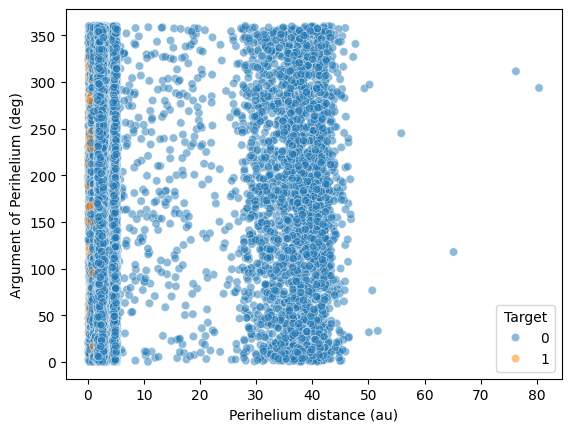

In [55]:
# Argument of Perihelium versus Perihelium distance:
sns.scatterplot(y=df_train['w'], x=df_train['q'], hue=df_train['Target'], alpha=0.5)
plt.xlabel("Perihelium distance (au)")
plt.ylabel("Argument of Perihelium (deg)")
plt.show()

Observations:

- There is a lack of Asteroids that have Perihelium distance between approximately 5 astronomic units and 30 astronomic units and argument of perihelium varing between zero and 360 degrees.

#### Absolute Magnitude

Absolute Magnitude: It is defined as the apparent magnitude that an object would appear to have if it were situated at a distance of 10 parsec.

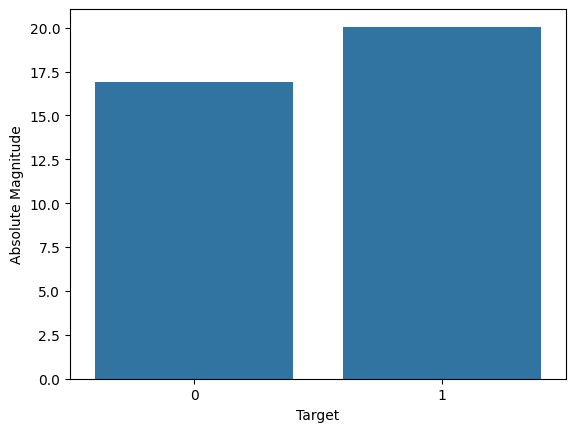

In [56]:
group = df_train.groupby('Target').agg({'H':'mean'}).reset_index()
sns.barplot(x=group['Target'], y=group['H'])
plt.ylabel("Absolute Magnitude")
plt.show()

Observations:
- With the definition in mind, it is evident that the asteroids pontentially dangerous have more luminoisty than the others.

#### Time of perihelium passage calibrated (tp_cal) and Time of perihelium passage (tp)

The time of perihelium passage: It is the time that a celestial body in an elliptical orbit, reaches its closest point to the sun.

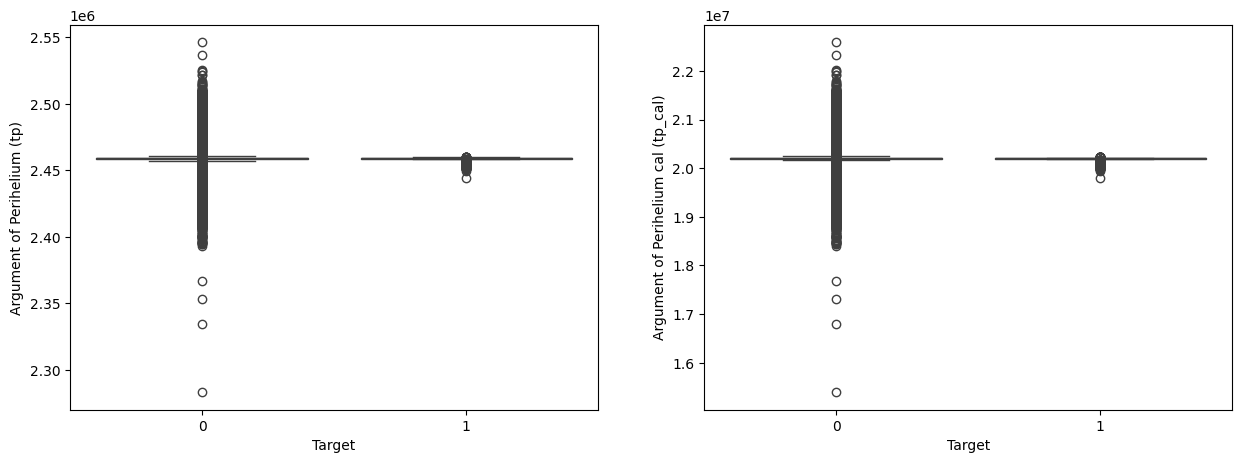

In [57]:
# Boxplots of Argument of Perihelium (tp) and Argument of Perihelium calibrated (tp_cal) per class:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5), sharex=False, sharey=False)

sns.boxplot(y=df_train['tp'], x=df_train['Target'], ax=ax[0])
ax[0].set_ylabel("Argument of Perihelium (tp)")

sns.boxplot(y=df_train['tp_cal'], x=df_train['Target'], ax=ax[1])
ax[1].set_ylabel("Argument of Perihelium cal (tp_cal)")

plt.show()

Observations

- Looking at these plots, we can see that the Argument of Perihelium (tp) has lower magnitude than the Argument of Perihelium cal. Furthermore, they are extremly correlated. So, we are going to keep Argument of Perihelium, due to its magnitude of values.

- There distribution of each group of Argument of Perihelium appears not to be very different because the boxplots are overlapping, as the Mann Whitney test worked.

In [58]:
# Dropping the Argument of Perihelium cal:
df_train.drop(columns=['tp_cal'], inplace=True)
X_test.drop(columns=['tp_cal'], inplace=True)

## 4) Preprocessing

In [59]:
# Splitting the training dataframe:
X_train = df_train.drop(columns='Target')

In [60]:
# Numeric columns without the tp_cal column:
numeric_columns = [i for i in numeric_columns if i != 'tp_cal']

### 4.1) Categorical Transformation

#### 4.1.1) One hot Encoder

In [61]:
# Transforming the categorical attributes into dummy variables:
X_train_dummy = pd.get_dummies(X_train, drop_first=True, dtype=bool)
X_test_dummy = pd.get_dummies(X_test, drop_first=True, dtype=bool)

### 4.2) Feature Selection

In [62]:
# Class that put together many feature selection techniques:

class feature_selector:
    seed = 42
    def __init__(self, X, y) -> None:
        self.X_train = X
        self.y_train = y

    def  randomforestC_imp(self) -> None:
        model = RandomForestClassifier(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        # Plotting RandomForest Regression Importance:
        plt.figure(figsize=(15, 15))
        plt.title("RandomForest Importance")
        plt.xlabel("Importance")
        sns.barplot(x=series.values, y=series.index)


    def xgbC_imp(self) -> None:
        model = XGBClassifier(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        # Plotting XGboost Regression Feature Importance:
        plt.figure(figsize=(15,15))
        plt.title("XGBoost Feature Importance")
        plt.xlabel("Importance")
        sns.barplot(y=series.index, x=series.values)

    # Univariate feature selection:
    def univariate(self, statistic, n="all") -> None:
        selector = SelectKBest(score_func=statistic, k=n)
        selector.fit(self.X_train, self.y_train)

        series = pd.Series(index=selector.feature_names_in_, data=selector.scores_).\
            sort_values(ascending=False)
        plt.title("Univariate feature selection - Filtering")
        sns.barplot(y=series.index, x=series.values)

        return selector

    # Wrapper method for feature selection:
    
    def refcv(self):
        models = {
            "RandomForestR": RandomForestClassifier(random_state=feature_selector.seed, n_estimators=50, n_jobs=-1),
            "ExtraTreeR": ExtraTreesClassifier(random_state=feature_selector.seed, n_estimators=50, n_jobs=-1),
            "XGB": XGBClassifier(random_state=feature_selector.seed, n_jobs=-1)
        }

        splits = 5
        step = 5
        min_features = 10
        cross = StratifiedKFold(n_splits=splits, random_state=feature_selector.seed, shuffle=True)

        # Prepare an empty DataFrame to store results
        df = pd.DataFrame()

        minimo = -np.inf
        name = ""
    
        for key, model in models.items():
            rfecv = RFECV(estimator=model, step=step, cv=cross, min_features_to_select=min_features, scoring="f1")
            rfecv.fit(self.X_train, self.y_train)
        
            # Dynamically adjust index length based on rfecv.cv_results_ length
            root_mean = rfecv.cv_results_["mean_test_score"]
            df_key_index = [f"Columns {i}" for i in range(min_features, min_features + len(root_mean))]
        
            # Add column to df with root_mean scores and dynamically set index length
            df[key] = pd.Series(data=root_mean, index=df_key_index)

            # Store best features if the model's score is higher
            best_value = root_mean[np.argmax(root_mean)]
            if best_value > minimo:
                minimo = best_value
                best_features = rfecv.support_
                name = key

        # Convert selected features to DataFrame
        df_features = pd.DataFrame(columns=self.X_train.columns, data=best_features.reshape(1, -1), index=[name])

        return df, df_features.transpose()

In [63]:
# Feature Selector object:
selector = feature_selector(X_train_dummy, y_train)

#### 4.1.1) Random Forest Importance

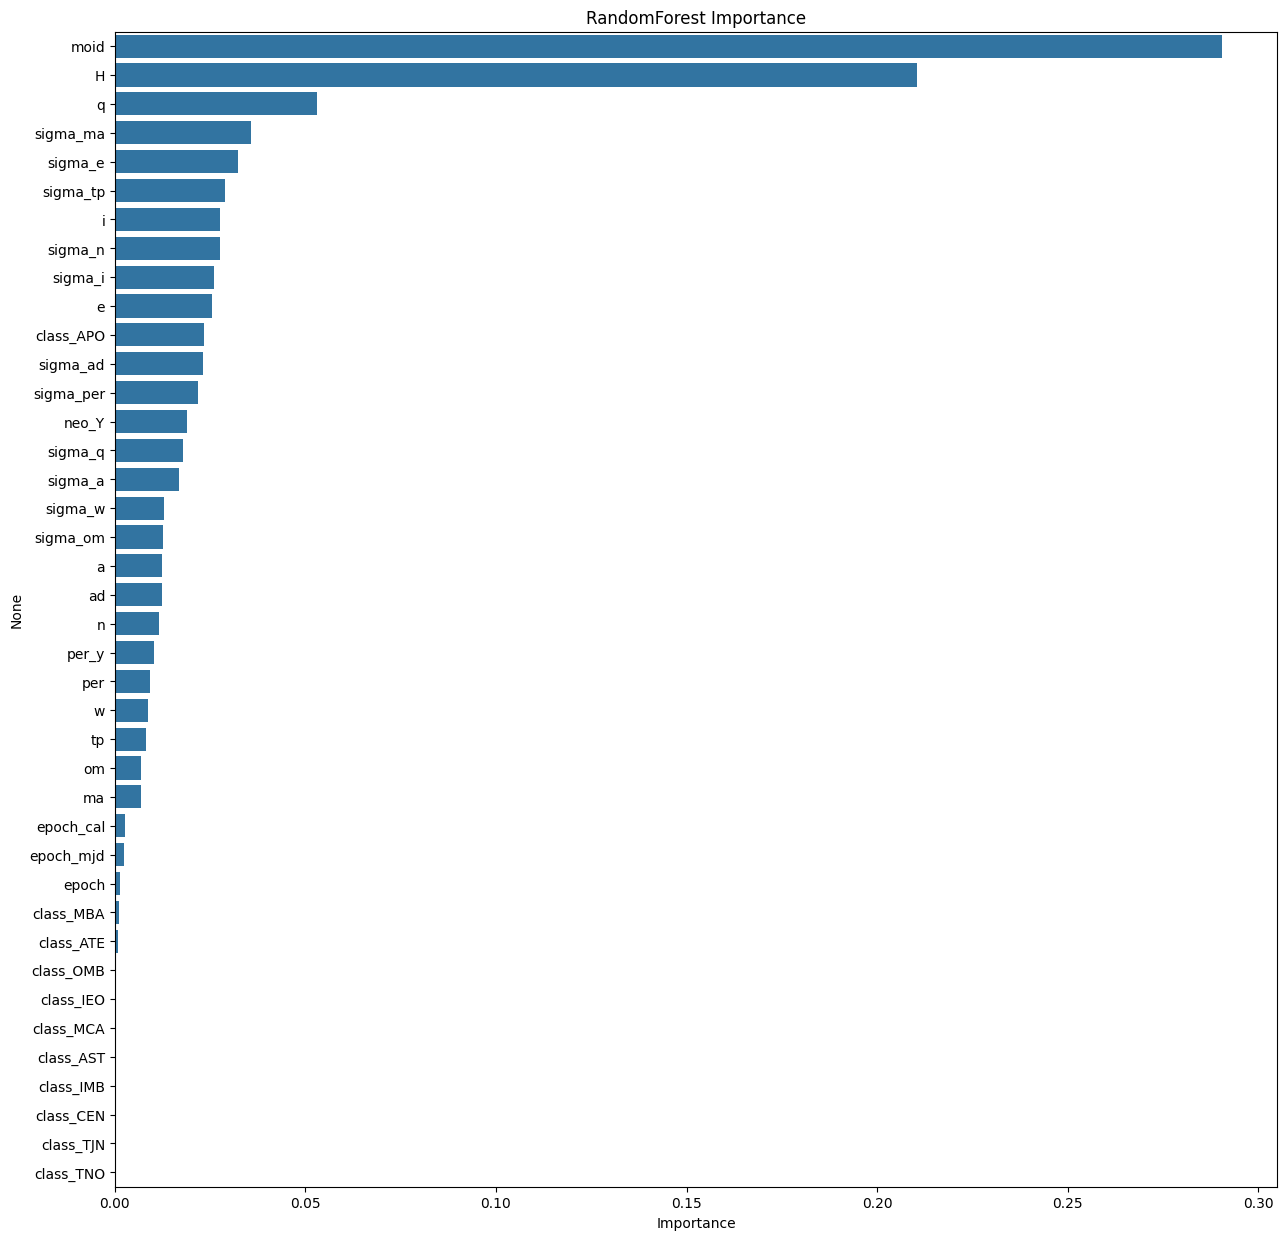

In [64]:
# Random Forest Importance:
selector.randomforestC_imp()

Observations:

- Earth Minimum Orbit Intersection Distance (moid) is the most important feature according to the Random Forest algorithm.

- Epoch, Epoch_cal, Epoch_mjd and the Orbit classes are the least important features to the model.

#### 4.1.2) XBGoost Importance

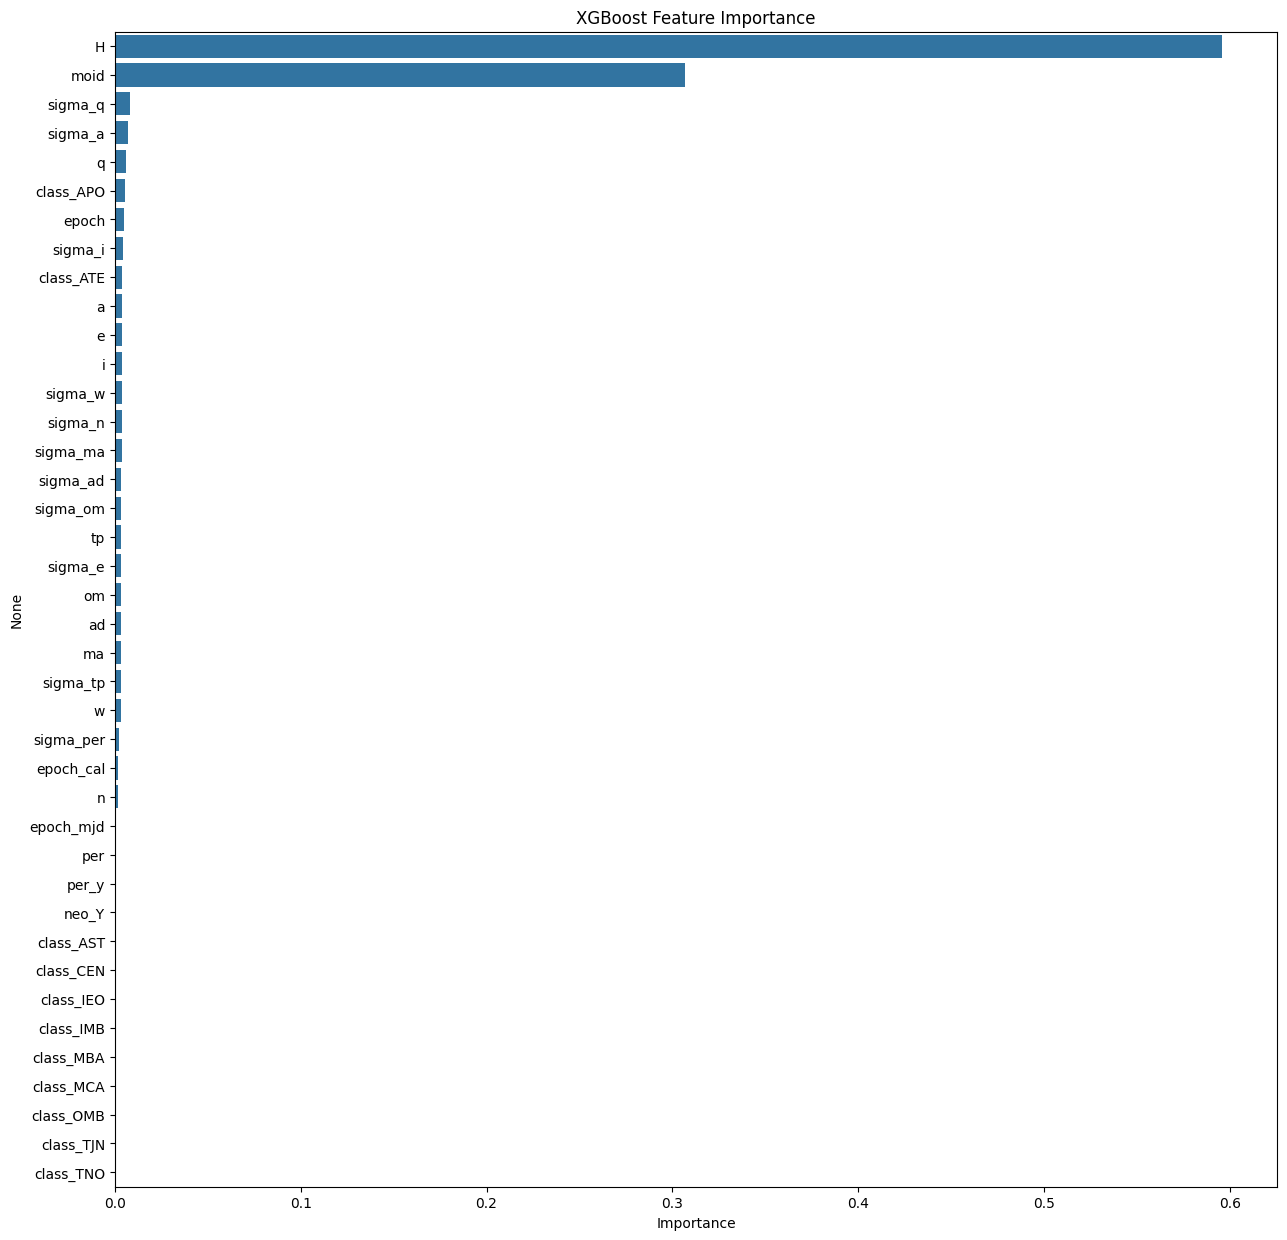

In [65]:
# XGBoost Classifier Importance:
selector.xgbC_imp()

Observations:

- According to the XGBoost Classifier the Absolute Magnitude (H) is the most important feature followed by Earth Minimum Orbit Intersection Distance (moid).

- It is interesting that all of the other features are practically irrelevants to the model.

-  class_TNO is the most irrelevant feature according to the XGBoost.

#### 4.1.3) Recursive Feature elimination

In [66]:
# Recusive feature elimination method:
df_results, df_best_features = selector.refcv()

In [67]:
# Results for each Algorithm:
df_results

,RandomForestR,ExtraTreeR,XGB
Columns 10,0.986307,0.906128,0.937467
Columns 11,0.984424,0.833742,0.936157
Columns 12,0.985662,0.844653,0.937584
Columns 13,0.986285,0.833808,0.936877
Columns 14,0.981640,0.799820,0.937797
Columns 15,0.976217,0.783072,0.937797
Columns 16,0.981334,0.782610,0.937797


In [68]:
# Best number set of features and the respective algorithm:
df_best_features

,RandomForestR
H,True
epoch,False
epoch_mjd,False
epoch_cal,False
e,True
a,False
q,True
i,True
om,False
w,False


Observations:
- According to the Recurrent feature elimination, XGBoost is the best Algorithm and the number of important features can be settled to 30 features.

In [69]:
# Selected columns:
columns_selected = ['H', 'epoch', 'epoch_cal', 'epoch_mjd', 'e', 'a', 'q', 'i', 'om', 'w',
                    'ma', 'ad', 'n', 'tp', 'per', 'moid', 'sigma_e', 'sigma_a', 'sigma_q',
                    'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n',
                    'sigma_tp', 'sigma_per', 'neo_Y', 'class_APO']

In [70]:
# Dropping unnecessary features:
X_train = X_train_dummy[columns_selected]
X_test = X_test_dummy[columns_selected]

In [71]:
# Exctracting new numeric columns:
numeric_columns = [c for c in X_train.columns if not pd.api.types.is_bool_dtype(X_train[c])]

### 4.3) Numerical Transformation

#### 4.3.1) Standard Scaler

Definition:
- The Standard Scaler is a technique that rescales the distribution of a variable so that the mean of the observed sample is 0 and the standard deviation is 1. It is particularly useful for algorithms that rely on distance measures, such as K-means and K-nearest neighbors (KNN). Additionally, it is a recommended choice for algorithms based on neural networks.

OBS: Standard Scaler can perform slightly worst than the other transformations because it assumes that the data is normally distributed. However you can still standardize your data.

Matematical Definition:

$X_{new_{i}} = \frac{X_{i} - \hat{\mu}_{i}}{\sigma_{i}}$

- $\mu:$ Mean of the sample.
- $\sigma:$ Standard Deviation of the sample.

In [72]:
# Copy of the train and test set:
X_train_std = X_train.copy()
X_test_std = X_test.copy()


# Fitting a Standard Scaler object:
std_scaler = StandardScaler()
X_train_std_numeric = std_scaler.fit_transform(X_train[numeric_columns])
X_test_std_numeric = std_scaler.transform(X_test[numeric_columns])

# Switching the old numeric columns by the normalized set of columns:
X_train_std[numeric_columns] = X_train_std_numeric
X_test_std[numeric_columns] = X_test_std_numeric

#### 4.3.2) Min Max Scaler

Definition:
- MinMax Scaler is also called as Normalization, which is a technique that rescale all the values, usually, within a range of 0 and 1.

Mathematical Definition:

$X_{new_{i}} = \frac{X_{i} - X_{min_{i}}}{X_{max_{i}} - X_{min_{i}}}$

In [73]:
# Copy of the train and test set:
X_train_min_max = X_train.copy()
X_test_min_max = X_test.copy()

# Fitting a Standard Scaler object:
min_max_scaler = RobustScaler()
X_train_min_max_numeric = min_max_scaler.fit_transform(X_train[numeric_columns])
X_test_min_max_numeric = min_max_scaler.transform(X_test[numeric_columns])

# Switching the old numeric columns by the normalized set of columns:
X_train_min_max[numeric_columns] = X_train_min_max_numeric
X_test_min_max[numeric_columns] = X_test_min_max_numeric

#### 4.3.3) Robust Scaler

Definition:
- Robust scaler is a technique which uses the median and the Interquartile range to transform the variables. This approach is very useful when the input variables have many outliers.

Mathematical Definition:

$X_{new_{i}} = \frac{X_{i} - median_{i}}{IQR_{i}}$

$IQR_{i} = P_{75_{i}} - P_{25_{i}}$

- $IQR:$ Interquartile Range.
- $P_{75}:$ 75th Percentile.
- $P_{25}:$ 25th Percentile.

In [74]:
# Copy of the train and test set:
X_train_rb = X_train.copy()
X_test_rb = X_test.copy()

# Fitting a Standard Scaler object:
rb_scaler = RobustScaler()
X_train_rb_numeric = rb_scaler.fit_transform(X_train[numeric_columns])
X_test_rb_numeric = rb_scaler.transform(X_test[numeric_columns])

# Switching the old numeric columns by the normalized set of columns:
X_train_rb[numeric_columns] = X_train_rb_numeric
X_test_rb[numeric_columns] = X_test_rb_numeric

### 4.4) Selecting the best algorithm and Transformation

In [75]:
def melhor_modelo(X_train, y_train):
    seed = 42
    cv = 5  # Reduced for initial testing
    result_f1 = {}

    models = {
        "RandomForestR": RandomForestClassifier(random_state=seed, n_jobs=-1, n_estimators=50),
        "ExtraTreeR": ExtraTreesClassifier(random_state=seed, n_jobs=-1, n_estimators=50),
        "XGB": XGBClassifier(random_state=seed, n_jobs=-1, n_estimators=50),
        "MLP": MLPClassifier(random_state=seed, max_iter=500, early_stopping=True)
    }

    k_fold = StratifiedKFold(n_splits=cv, random_state=seed, shuffle=True)
    for name, model in models.items():
        result = cross_validate(model, X_train, y_train, cv=k_fold, scoring={'f1': 'f1'}, n_jobs=-1)
        result_f1[name] = [result['test_f1'].mean(), result['test_f1'].std()]

    result_pd_f1 = pd.DataFrame(data=result_f1, index=['mean_f1', 'std_f1']).T
    return result_pd_f1


In [76]:
class Best_model_selector:
    seed = 42
    cv = 5  # Adjusted for initial testing

    def __init__(self, X_train, y_train) -> None:
        self.X_train = X_train
        self.y_train = y_train

    def best_model(self, scoring='f1', imbalance=False):
        result_f1 = {}
        models = {
            "RandomForestR": RandomForestClassifier(random_state=Best_model_selector.seed, n_jobs=-1, n_estimators=50),
            "ExtraTreeR": ExtraTreesClassifier(random_state=Best_model_selector.seed, n_jobs=-1, n_estimators=50),
            "XGB": XGBClassifier(random_state=Best_model_selector.seed, n_jobs=-1, n_estimators=50),
            "MLP": MLPClassifier(random_state=Best_model_selector.seed, max_iter=500, early_stopping=True)
        }

        k_fold = StratifiedKFold(n_splits=Best_model_selector.cv, random_state=Best_model_selector.seed, shuffle=True)
       
        for name, model in models.items():
            if imbalance:
                categorical_index = [
                    self.X_train.columns.get_loc(c) for c in self.X_train.columns if pd.api.types.is_bool_dtype(self.X_train[c])
                ]
                pipeline = make_pipeline(SMOTENC(categorical_features=categorical_index, random_state=Best_model_selector.seed), model)
                result = cross_validate(pipeline, self.X_train, self.y_train, cv=k_fold, scoring={'f1': scoring}, n_jobs=-1)
            else:
                result = cross_validate(model, self.X_train, self.y_train, cv=k_fold, scoring={'f1': scoring}, n_jobs=-1)

            result_f1[name] = [result['test_f1'].mean(), result['test_f1'].std()]

        result_pd_f1 = pd.DataFrame(data=result_f1, index=[f'mean_{scoring}', f'std_{scoring}']).T
        return result_pd_f1


#### 4.4.1) Using Standard Scaler

In [77]:
# Instace of the best model selector:
model_selector = Best_model_selector(X_train_std, y_train)

In [78]:
# Best algorithm results using Standard Scaler:
result_std = model_selector.best_model()
result_std.describe()

,mean_f1,std_f1
count,4.000000,4.000000
mean,0.841656,0.019774
std,0.157678,0.023347
min,0.630826,0.002494
25%,0.768565,0.007096
50%,0.875977,0.011254
75%,0.949068,0.023932
max,0.983844,0.054092


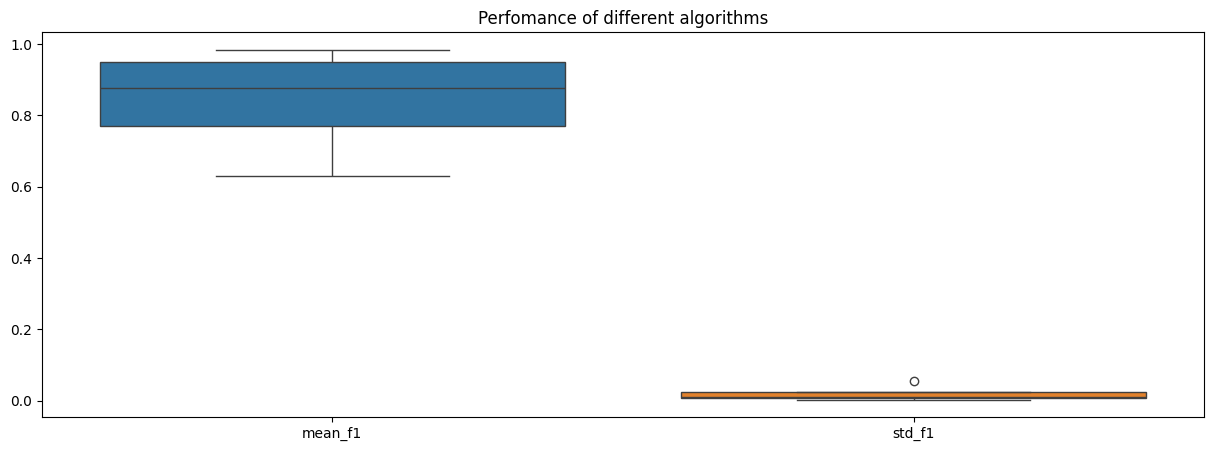

In [79]:
# Plotting a boxplot for model's evaluation:
plt.figure(figsize=(15, 5))
plt.title("Perfomance of different algorithms")
sns.boxplot(result_std)
plt.show()

#### 4.4.2) Using Min Max Scaler

In [80]:
# Instace of the best model selector:
model_selector = Best_model_selector(X_train_min_max, y_train)

In [81]:
# Best algorithm results using Min max Scaler:
result_min_max = model_selector.best_model()
result_min_max.describe()

,mean_f1,std_f1
count,4.000000,4.000000
mean,0.764051,0.043395
std,0.307569,0.071353
min,0.314333,0.002410
25%,0.694083,0.004702
50%,0.879017,0.010541
75%,0.948985,0.049234
max,0.983836,0.150090


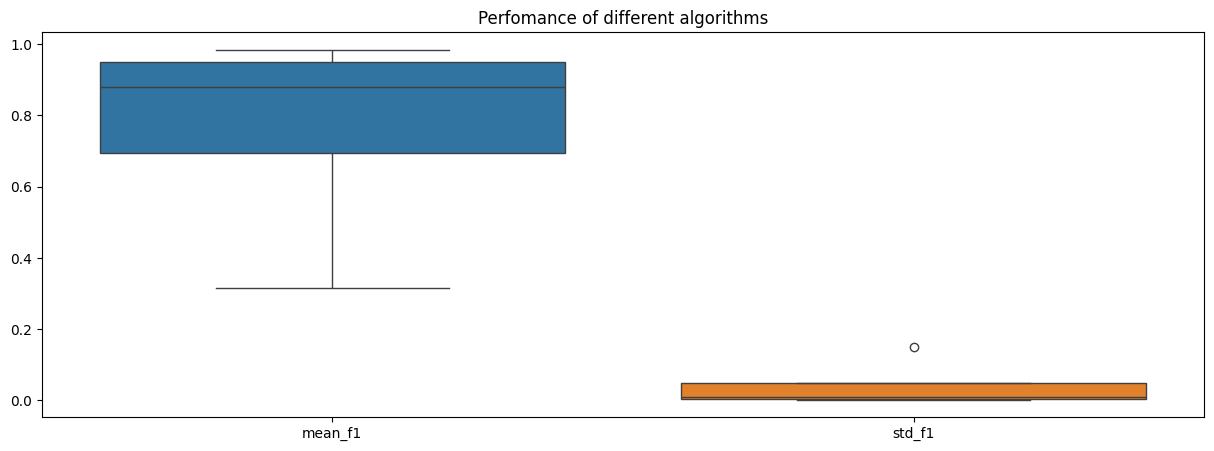

In [82]:
# Plotting a boxplot for model's evaluation:
plt.figure(figsize=(15, 5))
plt.title("Perfomance of different algorithms")
sns.boxplot(result_min_max)
plt.show()

#### 4.4.3) Using Robust Scaler

In [83]:
# Instace of the best model selector:
model_selector = Best_model_selector(X_train_rb, y_train)

In [84]:
# Best algorithm:
result_rb = model_selector.best_model()
result_rb.describe()

,mean_f1,std_f1
count,4.000000,4.000000
mean,0.764051,0.043395
std,0.307569,0.071353
min,0.314333,0.002410
25%,0.694083,0.004702
50%,0.879017,0.010541
75%,0.948985,0.049234
max,0.983836,0.150090


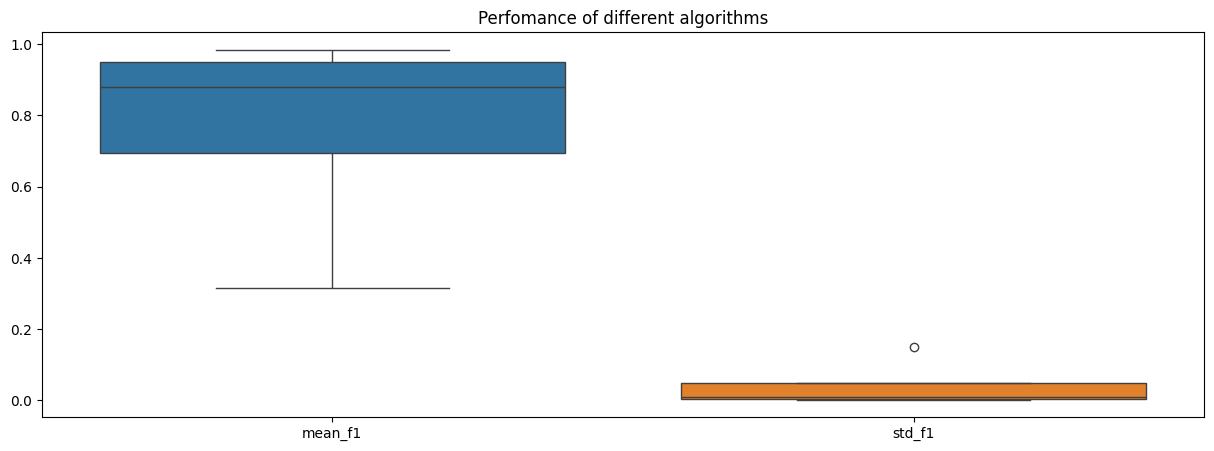

In [85]:
# Plotting a boxplot for model's evaluation:
plt.figure(figsize=(15, 5))
plt.title("Perfomance of different algorithms")
sns.boxplot(result_rb)
plt.show()

Observations:

- Best Algorithms are XGBoost using Robust Scale or Min max Scaler as numeric transformation, Average score of 0.985622a dn Standard Deviation of 0.006369.

### 4.5) SMOTENC - Synthetic Minority Over Sampling Technique for Nominal and Continous.

SMOTENC is a technique for orver sampling new records based on the records of the minority class. This approach is used when a imbalanced dataset and its algorithm can be seen below:

1. Find all the observations that compose the minority class.

2. Distinguishe between the categorical and continous columns.

3. Find the k nearest neighbors, this parameter can be settled by the user, for each observation.

4. Afterward, it is chosen randomly one of the k nearest observations and it is computed de difference between their continuous features, multiplied by a number between 0 and 1, and then added to the original continuous feature values. For categorical features, a random categoy is chosen from the k nearest neighbors.

5. Repeat steps 3 and 4 until reaches the number of synthetic samples.  

#### 4.5.1) SMOTENC with Standard Scaler

In [86]:
# Instace of the best model selector:
model_selector = Best_model_selector(X_train_std, y_train)

In [87]:
# Best algorithm:
result_sm_std = model_selector.best_model(imbalance=True)
result_sm_std.describe()

,mean_f1,std_f1
count,4.000000,4.000000
mean,0.892493,0.012015
std,0.103640,0.009186
min,0.755922,0.003512
25%,0.840506,0.006012
50%,0.916389,0.010095
75%,0.968376,0.016098
max,0.981271,0.024359


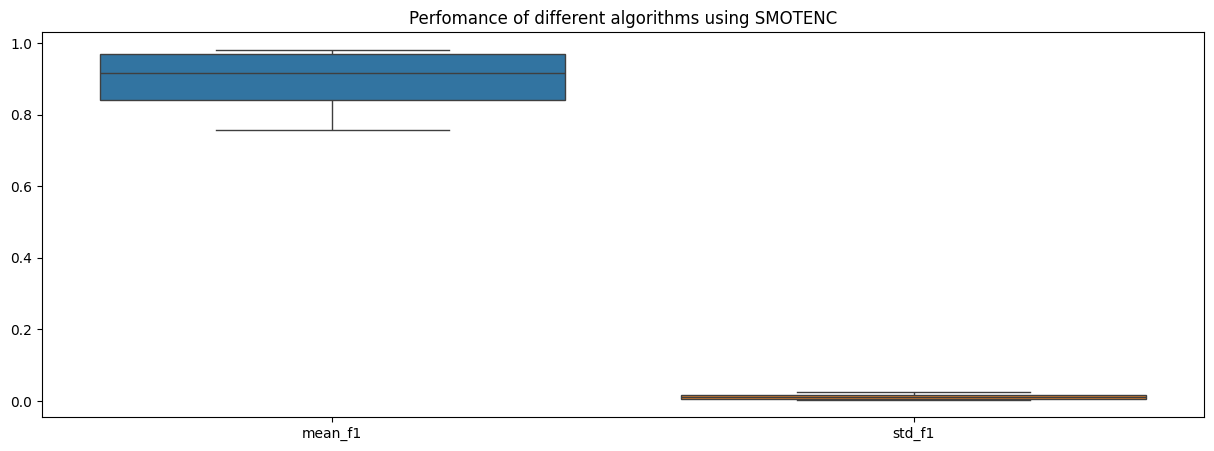

In [88]:
# Plotting a boxplot for model's evaluation:
plt.figure(figsize=(15, 5))
plt.title("Perfomance of different algorithms using SMOTENC")
sns.boxplot(result_sm_std)
plt.show()

#### 4.5.2) SMOTENC with Min Max Scaler

In [89]:
# Instace of the best model selector:
model_selector = Best_model_selector(X_train_min_max, y_train)

In [90]:
# Best algorithm:
result_sm_min_max = model_selector.best_model(imbalance=True)
result_sm_min_max.describe()

,mean_f1,std_f1
count,4.000000,4.000000
mean,0.764460,0.013228
std,0.363703,0.012403
min,0.221954,0.003813
25%,0.724246,0.005449
50%,0.928196,0.009004
75%,0.968410,0.016784
max,0.979494,0.031091


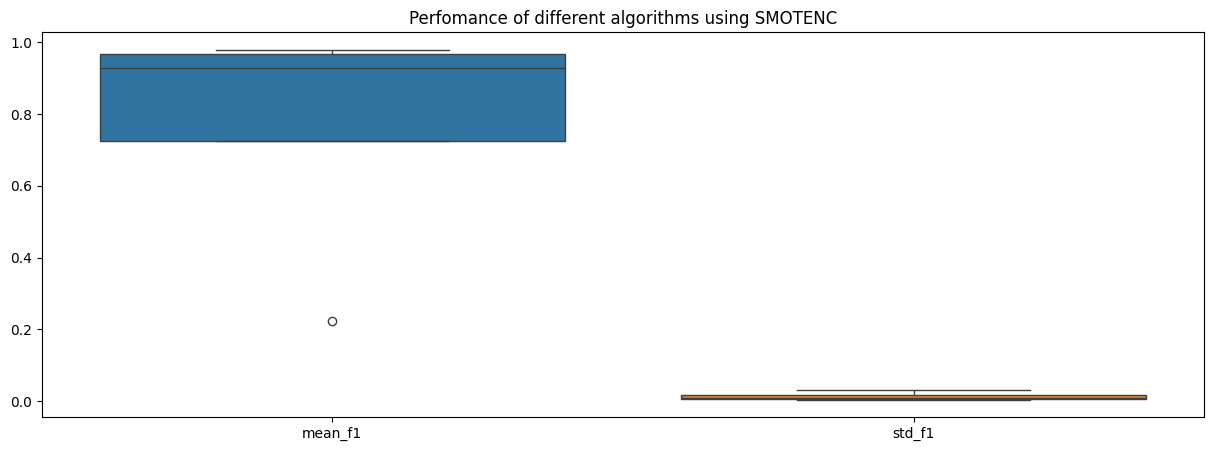

In [91]:
# Plotting a boxplot for model's evaluation:
plt.figure(figsize=(15, 5))
plt.title("Perfomance of different algorithms using SMOTENC")
sns.boxplot(result_sm_min_max)
plt.show()

#### 4.5.3) SMOTENC with Robust Scaler

In [92]:
# Instace of the best model selector:
model_selector = Best_model_selector(X_train_rb, y_train)

In [93]:
# Best algorithm:
result_sm_rb = model_selector.best_model(imbalance=True)
result_sm_rb.describe()

,mean_f1,std_f1
count,4.000000,4.000000
mean,0.764460,0.013228
std,0.363703,0.012403
min,0.221954,0.003813
25%,0.724246,0.005449
50%,0.928196,0.009004
75%,0.968410,0.016784
max,0.979494,0.031091


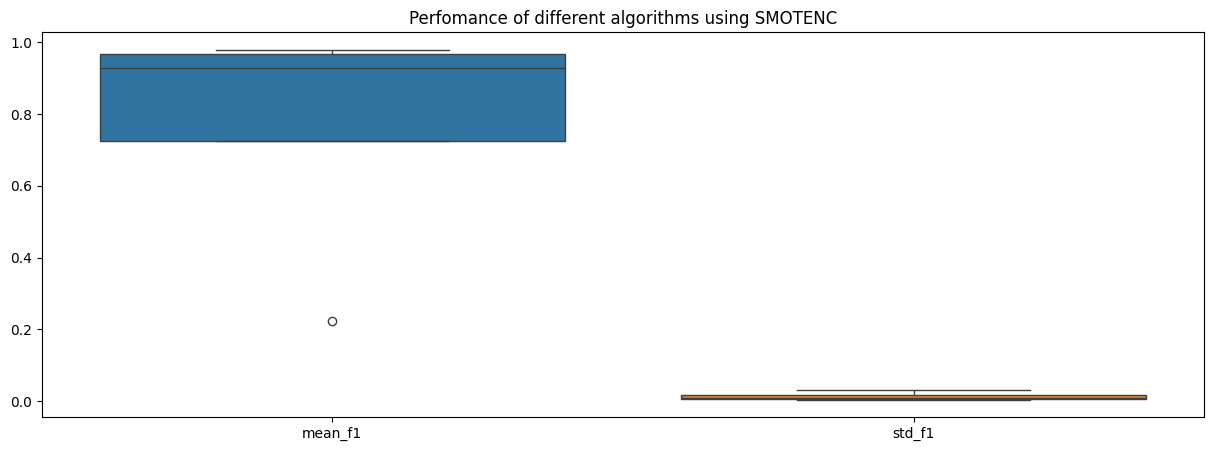

In [94]:
# Plotting a boxplot for model's evaluation:
plt.figure(figsize=(15, 5))
plt.title("Perfomance of different algorithms using SMOTENC")
sns.boxplot(result_sm_rb)
plt.show()

Observations:

- Best algorithm was Standard Scaler with XGBoost Classifier but it worse compared to the pipeline without the SMOTENC technique, so I am will not use it to fine tune the model.

- We will an XGBoost with the Robust Scaler transformation without SMOTENC, because it is more robust to ouliers and it had one of the highest scores, so it might be an good approach.

## 5) Fine Tuning

In [95]:
# Function for fine tuning an arbitrary model:
def tuning(X_train, y_train, modelo, params):

    cv = 5
    score = "f1"
    grid  = GridSearchCV(modelo, cv=cv, param_grid=params,
                         scoring=score,
                         n_jobs=-1,
                         return_train_score=True,
                         )

    grid.fit(X_train, y_train)

    best_index = grid.best_index_
    result = grid.cv_results_

    train_score = result['mean_train_score'][best_index]
    left_out = result['mean_test_score'][best_index]


    print(f"Train score: {train_score}")
    print(f"Left out data score: {left_out}")

    return grid.best_params_

In [96]:
# Function that creates a directory named model and save a model in joblib format:
def save_model(model, name):
    try:
        joblib.dump(model, "model/{}".format(name))
    except:
        os.makedirs("model")
        path = "model/{}".format(name)
        joblib.dump(model, path)

In [97]:
# Hyperparameter grid for XGBoost:
params = {
    'n_estimators':[100, 120, 150],
    'max_depth':[5, 6, 7, 8],
    'eta':[0.3, 0.01, 0.001],
    'max_delta_step':[0, 0.5, 1],
    'tree_method':['gpu_hist']
}

In [98]:
# Fine Tuning the mode:
best_algorithm = XGBClassifier( random_state=42)
best_params = tuning(X_train_rb, y_train, best_algorithm, params)

c:\Users\kirta\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Train score: 0.9454985709059057
Left out data score: 0.9411262071004327


The model does not suffer from Overfitting.

In [99]:
# Best params:
best_params

{'eta': 0.01,
 'max_delta_step': 0,
 'max_depth': 7,
 'n_estimators': 150,
 'tree_method': 'gpu_hist'}

In [100]:
# Training the model with the whole training set:
best_estimator = XGBClassifier(**best_params)
best_estimator.fit(X_train, y_train)

c:\Users\kirta\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)

In [101]:
# Saving the model:
save_model(best_estimator, "xgb.joblib")

c:\Users\kirta\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


## 6) Results

### 6.1) Useful functions

In [102]:
# Function to calculate classification metrics and create a dataframe:
def metrics(y_true, y_pred):
    index_metrics = ['Accuracy', 'F1-score', 'Recall', 'Precision']
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    metrics_df = pd.DataFrame(dict(Metrics=[accuracy, f1, recall, precision]), index=index_metrics)
    return metrics_df

# Function to calculate the Area under the curve and plot the ROC-Curve:
def compute_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:, 1], pos_label=1)
    auc = roc_auc_score(y_true, y_score[:, 1])
    plt.title("ROC Curve")
    sns.lineplot(x=fpr, y=tpr)
    sns.lineplot(x=fpr, y=fpr, color='r')
    plt.xlabel("False Postive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    return auc

### 6.2) Predictions

In [103]:
# loading the model:
path = os.path.join('model', 'xgb.joblib')
model = joblib.load(path)

In [104]:
# Making predictions on the test set:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

# Making predictions on the trainin set:
y_pred_train = model.predict(X_train)

c:\Users\kirta\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\kirta\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the d

#### 6.2.1) Confusion Matrix

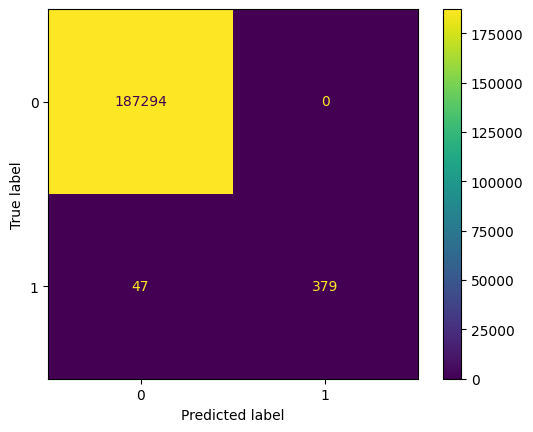

In [105]:
# Confusion Matrix:
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=model.classes_)
figure.plot();

Observations:

- *TP*: Number of Positive observations that was correclty predicted (379).

- *TN*: Number of Negative observations that was correctly predicted (187293).

- *FP*: Number of Negative observations that was predicted as positive (1).

- *FN*: Number of Positive observations that was predicted as negative (47).

#### 6.2.2) Classification metrics

In [106]:
# Metrics for test set and training set:
metrics_test = metrics(y_test, y_pred)
metrics_train = metrics(y_train, y_pred_train)

# Dataframe display:
print("Train metrics:")
display(metrics_train)

# Dataframe display:
print("Test metrics:")
display(metrics_test)

Train metrics:


,Metrics
Accuracy,0.999764
F1-score,0.942958
Recall,0.892073
Precision,1.000000


Test metrics:


,Metrics
Accuracy,0.999750
F1-score,0.941615
Recall,0.889671
Precision,1.000000


Obserations:

- The model perfomed very well on the test set for all metrics.

- Recall was the worst metric compared to others but is still a good value. Furthemore, it might be possible to elevate the recall, since for this type of problem is more important to have a hight Recall than a hight precision, because a potentially dangerous asteroid is more dangerous if it is classified as a negative class (not dagerous).

#### 6.2.3) ROC Curve and Area Under the Curve

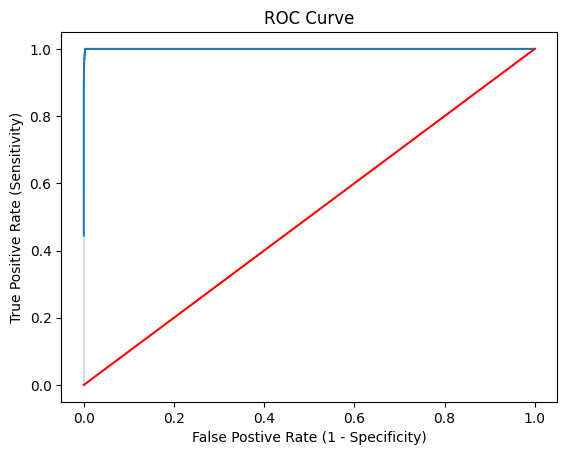

In [107]:
# Calculating ROC-Curve and Area under the curve:
auc = compute_roc_curve(y_test, y_prob)

In [108]:
# Area under the curve metric on the test set:
print('Test set:')
print(f"Area under the roc curve: {auc}")

Test set:
Area under the roc curve: 0.999910349077855


Observations:

- The Roc Curve above shows that the model can separete the classes really well, since the Area under the ROC Curve is almost one.